# Классификация 128x128 + U-Net c бэкбоном

## Датасеты
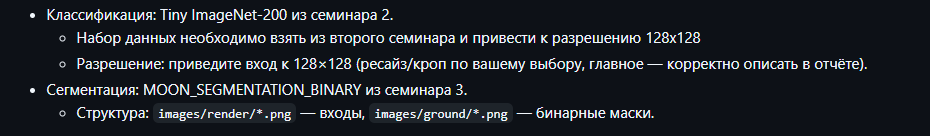

In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2025-12-15 18:28:14--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-12-15 18:28:14--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  14.6MB/s    in 17s     

2025-12-15 18:28:31 (14.2 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [2]:
!unzip -q tiny-imagenet-200.zip

In [3]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir

        # все 200 классов
        with open(os.path.join(root_dir, 'wnids.txt')) as f:
            self.wnids = [line.strip() for line in f]

        self.class_to_idx = {wnid: i for i, wnid in enumerate(self.wnids)}

        self.samples = []
        self._load_train()
        self._load_val()

    def _load_train(self):
        train_dir = os.path.join(self.root_dir, 'train')
        for wnid in os.listdir(train_dir):
            img_dir = os.path.join(train_dir, wnid, 'images')
            if not os.path.isdir(img_dir):
                continue
            for img in os.listdir(img_dir):
                path = os.path.join(img_dir, img)
                label = self.class_to_idx[wnid]
                self.samples.append((path, label))

    def _load_val(self):
        val_img_dir = os.path.join(self.root_dir, 'val', 'images')
        anno_file = os.path.join(self.root_dir, 'val', 'val_annotations.txt')

        img_to_wnid = {}
        with open(anno_file) as f:
            for line in f:
                img, wnid, *_ = line.strip().split('\t')
                img_to_wnid[img] = wnid

        for img, wnid in img_to_wnid.items():
            path = os.path.join(val_img_dir, img)
            label = self.class_to_idx[wnid]
            self.samples.append((path, label))

    def __len__(self):
        return len(self.samples)

In [5]:
class SubsetDataset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, label

In [6]:
full_dataset = TinyImageNetDataset("/content/tiny-imagenet-200")

all_samples = full_dataset.samples
all_labels = [label for _, label in all_samples]

In [7]:
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)
# стратифицированное разбиение
train_idx, val_idx = next(sss.split(all_samples, all_labels))

train_samples = [all_samples[i] for i in train_idx]
val_samples   = [all_samples[i] for i in val_idx]

print(f"Train: {len(train_samples)} \nVal: {len(val_samples)}")

Train: 88000 
Val: 22000


In [8]:
selectedClasses = [ #из второго семинара
    'n02124075', #Egyptian cat
    'n02917067', #bullet train, bullet
    'n07873807', #pizza, pizza pie
    'n03424325', #gasmask
    'n03970156', #plunger, plumber's helper --
    'n01882714', #koala
    'n04023962', #punching bag, punch bag, punching ball, punchball
    'n07749582', #lemon
    'n09246464', #cliff
    'n12267677'  #acorn
  ];

In [9]:
wnid_to_idx = full_dataset.class_to_idx
selected_classes = [wnid_to_idx[w] for w in selectedClasses]
train_samples = [s for s in train_samples if s[1] in selected_classes]
val_samples   = [s for s in val_samples if s[1] in selected_classes]

print(f"Train изображений: {len(train_samples)}\nVal изображений: {len(val_samples)}")

Train изображений: 4400
Val изображений: 1100


In [10]:
new_label_map = {old: new for new, old in enumerate(selected_classes)}
def remap(samples):
    return [(path, new_label_map[label]) for path, label in samples]

train_samples = remap(train_samples)
val_samples   = remap(val_samples)

### Датасет и лоадер

In [11]:
train_transform = transforms.Compose([
    transforms.Resize(144),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


In [12]:
train_dataset = SubsetDataset(train_samples, train_transform)
val_dataset   = SubsetDataset(val_samples, val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Часть 1. Классификатор 128×128

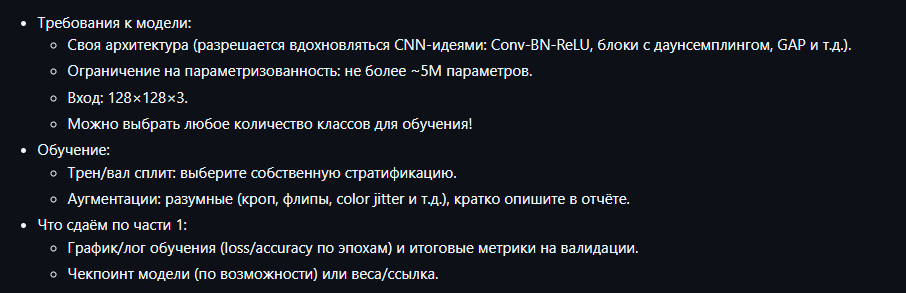

In [13]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.activation = nn.GELU()

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.activation(out)
        return out

In [14]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10, num_blocks=[1,1,1,1]):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.gelu = nn.GELU()

        self.layer1 = self._make_layer(32, 32,  num_blocks=num_blocks[0], stride=1)
        self.layer2 = self._make_layer(32, 64,  num_blocks=num_blocks[1], stride=2)
        self.layer3 = self._make_layer(64, 128, num_blocks=num_blocks[2], stride=2)
        self.layer4 = self._make_layer(128, 256, num_blocks=num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride=stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.gelu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [15]:
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    total_correct = 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()

    epoch_loss = total_loss / len(loader.dataset)
    epoch_acc = total_correct / len(loader.dataset)

    return epoch_loss, epoch_acc

def validate_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_correct = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Val", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item() * images.size(0)
            total_correct += (outputs.argmax(dim=1) == labels).sum().item()

    epoch_loss = total_loss / len(loader.dataset)
    epoch_acc = total_correct / len(loader.dataset)

    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, device, lr=0.001, epochs=25,
                optimizer_name="adam", save_path="best_model_classifier.pth"):
    model = model.to(device)

    loss_fn = nn.CrossEntropyLoss()

    if optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Для отслеживания лучшей модели
    best_val_acc = 0.0

    print(f"Training for {epochs} epochs...\n")

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}:")

        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_acc = validate_epoch(model, val_loader, loss_fn, device)

        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"  Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        # Сохраняем лучшую модель
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, save_path)
            print(f"  ✓ Saved best model with val_acc: {val_acc:.4f}")

    print(f"\nTraining finished! Best val accuracy: {best_val_acc:.4f}")
    print(f"Best model saved to: {save_path}")

    history = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "val_loss": val_losses,
        "val_acc": val_accs,
    }

    return model, history

In [16]:
model_Resnet = ResNet()
print(f"Всего параметров: {sum(p.numel() for p in model_Resnet.parameters()):,}")
test_input = torch.randn(1, 3, 64, 64)
output = model_Resnet(test_input)
print(output.shape)

Всего параметров: 1,228,970
torch.Size([1, 10])


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
model_Resnet, history_Resnet = train_model(
    model_Resnet,
    train_loader,
    val_loader,
    device,
    lr=0.001,
    epochs=40,
    save_path="resnet_classifier.pth"
)


Training for 40 epochs...

Epoch 1/40:


  Train Loss: 1.8517 | Train Acc: 0.3402
  Val   Loss: 1.7064 | Val   Acc: 0.4136
  ✓ Saved best model with val_acc: 0.4136
Epoch 2/40:


  Train Loss: 1.6101 | Train Acc: 0.4491
  Val   Loss: 1.4482 | Val   Acc: 0.4991
  ✓ Saved best model with val_acc: 0.4991
Epoch 3/40:


  Train Loss: 1.4739 | Train Acc: 0.4989
  Val   Loss: 1.3553 | Val   Acc: 0.5527
  ✓ Saved best model with val_acc: 0.5527
Epoch 4/40:


  Train Loss: 1.3842 | Train Acc: 0.5200
  Val   Loss: 1.3909 | Val   Acc: 0.5191
Epoch 5/40:


  Train Loss: 1.3086 | Train Acc: 0.5459
  Val   Loss: 1.2567 | Val   Acc: 0.5491
Epoch 6/40:


  Train Loss: 1.2324 | Train Acc: 0.5795
  Val   Loss: 1.2062 | Val   Acc: 0.5864
  ✓ Saved best model with val_acc: 0.5864
Epoch 7/40:


  Train Loss: 1.1918 | Train Acc: 0.5891
  Val   Loss: 1.3214 | Val   Acc: 0.5245
Epoch 8/40:


  Train Loss: 1.1339 | Train Acc: 0.6134
  Val   Loss: 1.2570 | Val   Acc: 0.5582
Epoch 9/40:


  Train Loss: 1.1188 | Train Acc: 0.6164
  Val   Loss: 1.0538 | Val   Acc: 0.6327
  ✓ Saved best model with val_acc: 0.6327
Epoch 10/40:


  Train Loss: 1.0697 | Train Acc: 0.6250
  Val   Loss: 1.2159 | Val   Acc: 0.5691
Epoch 11/40:


  Train Loss: 1.0552 | Train Acc: 0.6300
  Val   Loss: 1.1648 | Val   Acc: 0.5836
Epoch 12/40:


  Train Loss: 1.0385 | Train Acc: 0.6411
  Val   Loss: 1.0042 | Val   Acc: 0.6545
  ✓ Saved best model with val_acc: 0.6545
Epoch 13/40:


  Train Loss: 1.0036 | Train Acc: 0.6552
  Val   Loss: 1.0387 | Val   Acc: 0.6309
Epoch 14/40:


  Train Loss: 0.9703 | Train Acc: 0.6652
  Val   Loss: 0.9522 | Val   Acc: 0.6600
  ✓ Saved best model with val_acc: 0.6600
Epoch 15/40:


  Train Loss: 0.9572 | Train Acc: 0.6725
  Val   Loss: 1.0850 | Val   Acc: 0.6255
Epoch 16/40:


  Train Loss: 0.9492 | Train Acc: 0.6670
  Val   Loss: 0.9708 | Val   Acc: 0.6591
Epoch 17/40:


  Train Loss: 0.9402 | Train Acc: 0.6732
  Val   Loss: 1.0012 | Val   Acc: 0.6582
Epoch 18/40:


  Train Loss: 0.9034 | Train Acc: 0.6839
  Val   Loss: 1.1191 | Val   Acc: 0.6300
Epoch 19/40:


  Train Loss: 0.9147 | Train Acc: 0.6816
  Val   Loss: 1.0429 | Val   Acc: 0.6364
Epoch 20/40:


  Train Loss: 0.8671 | Train Acc: 0.6966
  Val   Loss: 1.0880 | Val   Acc: 0.6291
Epoch 21/40:


  Train Loss: 0.8709 | Train Acc: 0.6980
  Val   Loss: 0.8891 | Val   Acc: 0.6727
  ✓ Saved best model with val_acc: 0.6727
Epoch 22/40:


  Train Loss: 0.8433 | Train Acc: 0.7080
  Val   Loss: 0.9176 | Val   Acc: 0.6791
  ✓ Saved best model with val_acc: 0.6791
Epoch 23/40:


  Train Loss: 0.8363 | Train Acc: 0.7089
  Val   Loss: 0.8809 | Val   Acc: 0.6955
  ✓ Saved best model with val_acc: 0.6955
Epoch 24/40:


  Train Loss: 0.8101 | Train Acc: 0.7143
  Val   Loss: 0.8447 | Val   Acc: 0.7009
  ✓ Saved best model with val_acc: 0.7009
Epoch 25/40:


  Train Loss: 0.7955 | Train Acc: 0.7173
  Val   Loss: 0.9909 | Val   Acc: 0.6509
Epoch 26/40:


  Train Loss: 0.7885 | Train Acc: 0.7225
  Val   Loss: 0.9006 | Val   Acc: 0.6827
Epoch 27/40:


  Train Loss: 0.7825 | Train Acc: 0.7241
  Val   Loss: 0.9908 | Val   Acc: 0.6736
Epoch 28/40:


  Train Loss: 0.7383 | Train Acc: 0.7420
  Val   Loss: 0.7914 | Val   Acc: 0.7155
  ✓ Saved best model with val_acc: 0.7155
Epoch 29/40:


  Train Loss: 0.7427 | Train Acc: 0.7455
  Val   Loss: 0.8608 | Val   Acc: 0.6873
Epoch 30/40:


  Train Loss: 0.7256 | Train Acc: 0.7434
  Val   Loss: 0.8455 | Val   Acc: 0.6982
Epoch 31/40:


  Train Loss: 0.7343 | Train Acc: 0.7382
  Val   Loss: 0.9401 | Val   Acc: 0.6782
Epoch 32/40:


  Train Loss: 0.7098 | Train Acc: 0.7539
  Val   Loss: 1.0350 | Val   Acc: 0.6718
Epoch 33/40:


  Train Loss: 0.7089 | Train Acc: 0.7550
  Val   Loss: 0.8906 | Val   Acc: 0.6864
Epoch 34/40:


  Train Loss: 0.7016 | Train Acc: 0.7534
  Val   Loss: 0.8409 | Val   Acc: 0.7055
Epoch 35/40:


  Train Loss: 0.6861 | Train Acc: 0.7618
  Val   Loss: 0.9277 | Val   Acc: 0.6900
Epoch 36/40:


  Train Loss: 0.6915 | Train Acc: 0.7561
  Val   Loss: 0.8053 | Val   Acc: 0.7227
  ✓ Saved best model with val_acc: 0.7227
Epoch 37/40:


  Train Loss: 0.6818 | Train Acc: 0.7591
  Val   Loss: 1.0313 | Val   Acc: 0.6536
Epoch 38/40:


  Train Loss: 0.6641 | Train Acc: 0.7623
  Val   Loss: 0.9174 | Val   Acc: 0.6882
Epoch 39/40:


  Train Loss: 0.6299 | Train Acc: 0.7761
  Val   Loss: 0.9241 | Val   Acc: 0.6845
Epoch 40/40:


  Train Loss: 0.6182 | Train Acc: 0.7868
  Val   Loss: 0.8706 | Val   Acc: 0.7000

Training finished! Best val accuracy: 0.7227
Best model saved to: resnet_classifier.pth


### Графики

График обучения (loss/accuracy по эпохам) и итоговые метрики на валидации.

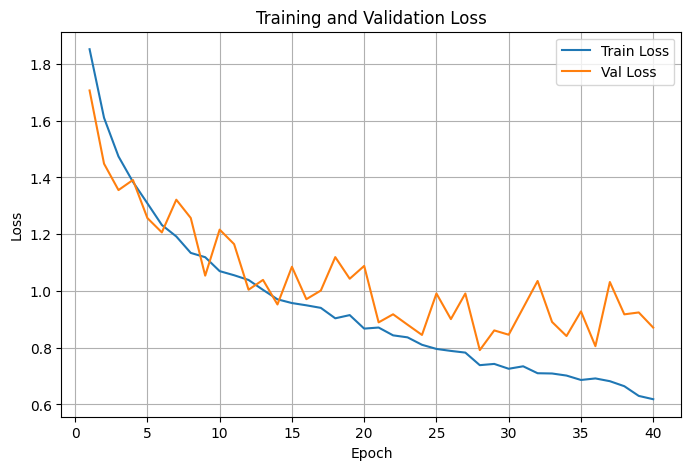

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_Resnet["train_loss"]) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history_Resnet["train_loss"], label="Train Loss")
plt.plot(epochs, history_Resnet["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Часть 2. Базовая U-Net на "Луне"
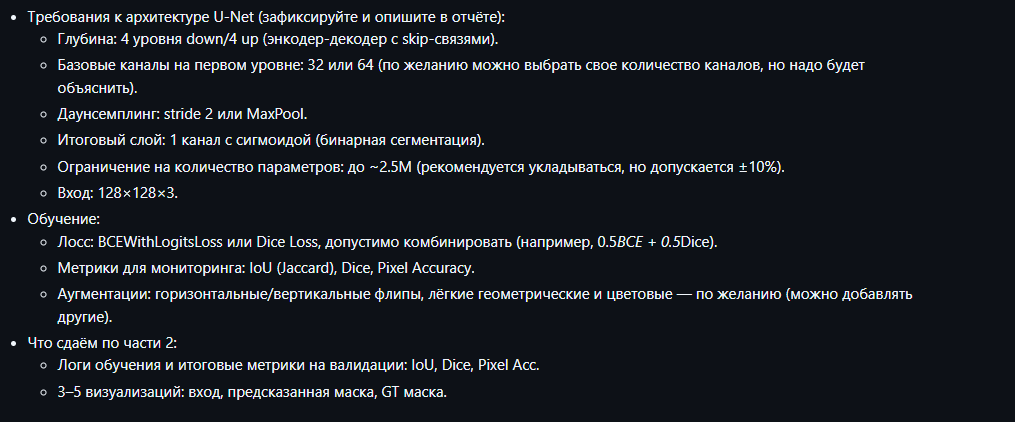

In [20]:
class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground',
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        images_dir = os.path.join(root_dir, 'images', image_folder)
        masks_dir = os.path.join(root_dir, 'images', mask_folder)

        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")

        # Для масок убираем префикс "render" если он есть
        # Например: render0001 - 0001
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_id}.png")

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Так как используем opencv, то не забываем преводить из BGR в RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Нормализуем бинарную маску к [0, 1]
        # 0 = фон, 1 = камни
        mask = (mask > 0).astype(np.float32)

        # Применяем аугментации
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Применяем предобработку
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

# Аугментации для обучения
train_augmentation = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7)),
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.MedianBlur(blur_limit=5),
    ], p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(128, 128),
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2819440945.py:65: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),


In [21]:
!unzip -q MOON_SEGMENTATION_BINARY.zip

In [22]:
from sklearn.model_selection import train_test_split

# Путь к данным
DATA_ROOT = "/content/MOON_SEGMENTATION_BINARY"

images_dir = os.path.join(DATA_ROOT, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')][:100]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

BATCH_SIZE = 4
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Батчей в train: {len(train_loader)}")
print(f"Батчей в val: {len(val_loader)}")

Всего изображений: 100
Train: 80 изображений
Val: 20 изображений
Батчей в train: 20
Батчей в val: 5


Размер батча изображений: torch.Size([4, 3, 128, 128])
Размер батча масок: torch.Size([4, 128, 128])


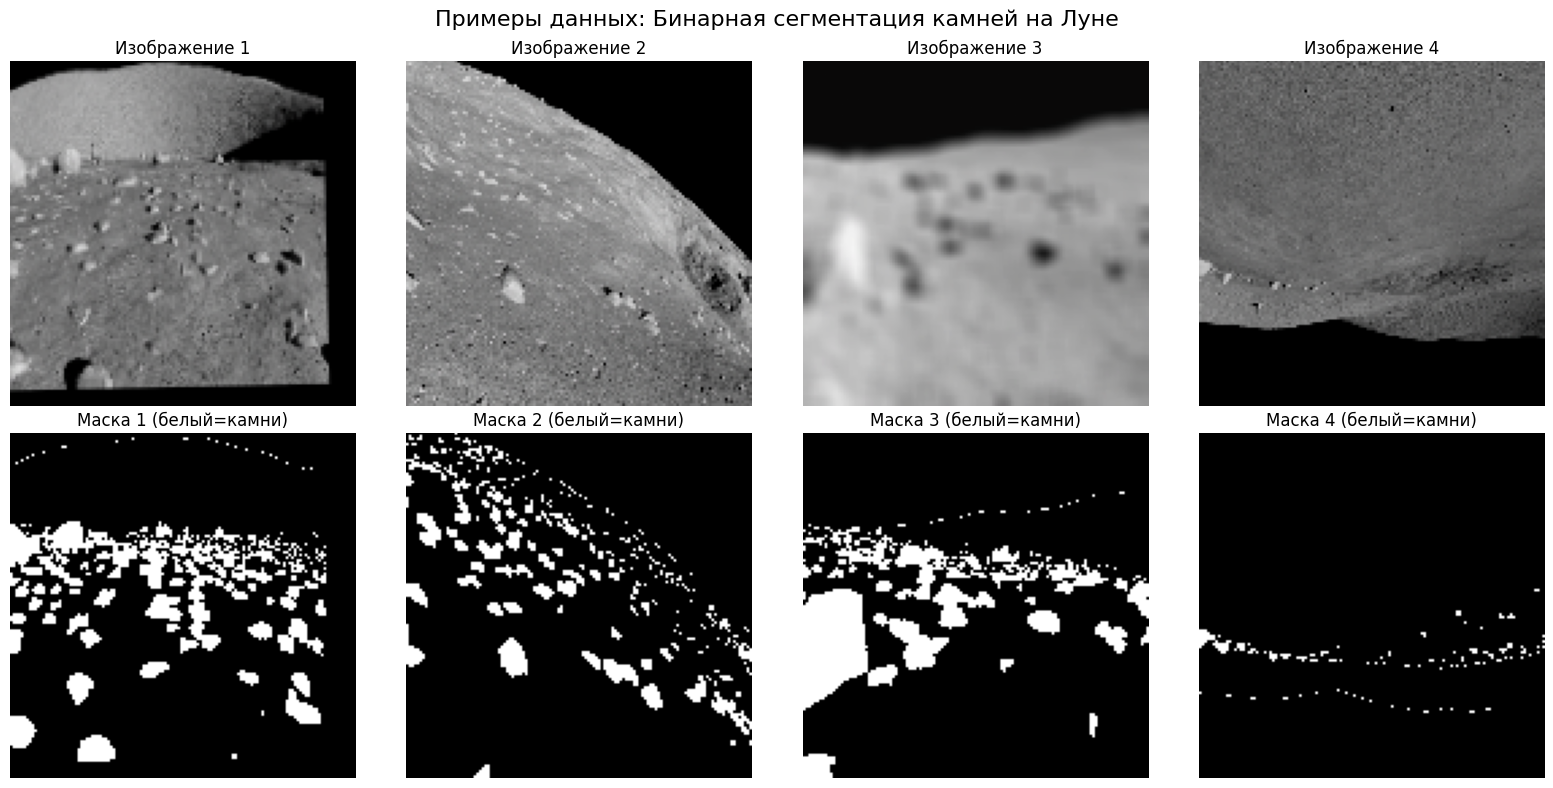

In [23]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

images, masks = next(iter(train_loader))

print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча масок: {masks.shape}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, len(images))):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    mask = masks[i].numpy()

    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Изображение {i+1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Маска {i+1} (белый=камни)")
    axes[1, i].axis('off')

plt.suptitle("Примеры данных: Бинарная сегментация камней на Луне", fontsize=16)
plt.tight_layout()
plt.show()

## U-NET

In [24]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [25]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super(UNet, self).__init__()

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(DoubleConv(prev_channels, feature))
            prev_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")

    def forward(self, x):

        skip_connections = []

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)

            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                mode='bilinear', align_corners=True)

            x = torch.cat([skip_connection, x], dim=1)

            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)

        return output

In [26]:
model = UNet(in_channels=3, out_channels=1, features = [16, 32, 64, 128])

test_input = torch.randn(1, 3, 128, 128)
test_output = model(test_input)
print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Параметров: 1,944,049
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])


Как-то параметров многовато выходит, если начинать с 32 (аж 7.8М), поэтому начинаю с 16. Пробовала изменить боттлнек, но параметров было все еще многовато

## Функции потерь и метрики для сегментации
Метрики сегментации:
Dice Loss - популярная функция потерь для сегментации

IoU (Intersection over Union) - метрика качества сегментации

Pixel Accuracy - точность предсказания пикселей

In [27]:
class DiceLoss(nn.Module):
    """
    Dice Loss для бинарной сегментации

    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)

        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)

        # Dice loss
        return 1 - dice


class CombinedLoss(nn.Module):

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)

        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)

    return dice.item()


def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)

    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()

    return (correct / total).item()

In [28]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()

    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0

    pbar = tqdm(train_loader, desc="Training")

    for images, masks in pbar:
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)

        running_loss += loss.item()
        running_dice += dice
        running_iou += iou

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })

    avg_loss = running_loss / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_iou = running_iou / len(train_loader)

    return avg_loss, avg_dice, avg_iou


def validate_epoch(model, val_loader, criterion, device):

    model.eval()

    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0

    pbar = tqdm(val_loader, desc="Validation")

    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)

            outputs = model(images)

            loss = criterion(outputs, masks)

            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)

            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            running_acc += acc

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'acc': f'{acc:.4f}'
            })

    avg_loss = running_loss / len(val_loader)
    avg_dice = running_dice / len(val_loader)
    avg_iou = running_iou / len(val_loader)
    avg_acc = running_acc / len(val_loader)

    return avg_loss, avg_dice, avg_iou, avg_acc

In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)

    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }

    best_val_dice = 0.0

    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")

        # Здесь происходит основное обучение
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Валидация
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )

        # Обновляем learning rate (проверяем на )
        if scheduler is not None:
            scheduler.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']

        # Сохраняем всю нашу историю
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        # Выводим результаты
        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")

        # Сохраняем лучшую модель, можно сохранять по метрике или loss
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")

    print(f"Лучший Val Dice: {best_val_dice:.4f}")

    return history

In [30]:
print(f"  Используем устройство: {device}")

  Используем устройство: cuda


In [67]:
# Функция потерь (комбинированная BCE + Dice)
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Планировщик learning rate (уменьшаем lr при плато)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
)

NUM_EPOCHS = 70

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path='best_moon_unet.pth'
)

Эпоха 1/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.24it/s, loss=0.6258, dice=0.3999, iou=0.2499, acc=0.9226]



 Результаты эпохи 1:
  Train - Loss: 0.6359, Dice: 0.3346, IoU: 0.2064
  Val   - Loss: 0.6237, Dice: 0.4652, IoU: 0.3044, Acc: 0.9105
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4652
Эпоха 2/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.58it/s, loss=0.5938, dice=0.3847, iou=0.2382, acc=0.9269]



 Результаты эпохи 2:
  Train - Loss: 0.6239, Dice: 0.3648, IoU: 0.2271
  Val   - Loss: 0.5947, Dice: 0.4675, IoU: 0.3076, Acc: 0.9166
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4675
Эпоха 3/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.30it/s, loss=0.6003, dice=0.3134, iou=0.1858, acc=0.9249]



 Результаты эпохи 3:
  Train - Loss: 0.6208, Dice: 0.4023, IoU: 0.2563
  Val   - Loss: 0.5887, Dice: 0.4186, IoU: 0.2666, Acc: 0.9175
  LR: 0.000100
Эпоха 4/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.67it/s, loss=0.6016, dice=0.4027, iou=0.2521, acc=0.9257]



 Результаты эпохи 4:
  Train - Loss: 0.6180, Dice: 0.3856, IoU: 0.2440
  Val   - Loss: 0.5930, Dice: 0.4807, IoU: 0.3184, Acc: 0.9167
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4807
Эпоха 5/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.75it/s, loss=0.6133, dice=0.4106, iou=0.2584, acc=0.9198]



 Результаты эпохи 5:
  Train - Loss: 0.6275, Dice: 0.3293, IoU: 0.2005
  Val   - Loss: 0.6030, Dice: 0.4655, IoU: 0.3044, Acc: 0.9110
  LR: 0.000100
Эпоха 6/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.99it/s, loss=0.6051, dice=0.3941, iou=0.2454, acc=0.9228]



 Результаты эпохи 6:
  Train - Loss: 0.6169, Dice: 0.3716, IoU: 0.2310
  Val   - Loss: 0.6044, Dice: 0.4681, IoU: 0.3074, Acc: 0.9078
  LR: 0.000100
Эпоха 7/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.38it/s, loss=0.5980, dice=0.3706, iou=0.2274, acc=0.9259]



 Результаты эпохи 7:
  Train - Loss: 0.6124, Dice: 0.3973, IoU: 0.2502
  Val   - Loss: 0.5798, Dice: 0.4572, IoU: 0.2986, Acc: 0.9188
  LR: 0.000100
Эпоха 8/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.06it/s, loss=0.5882, dice=0.3951, iou=0.2462, acc=0.9265]



 Результаты эпохи 8:
  Train - Loss: 0.6135, Dice: 0.3649, IoU: 0.2282
  Val   - Loss: 0.5819, Dice: 0.4697, IoU: 0.3087, Acc: 0.9155
  LR: 0.000050
Эпоха 9/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.25it/s, loss=0.5900, dice=0.4156, iou=0.2623, acc=0.9246]



 Результаты эпохи 9:
  Train - Loss: 0.6150, Dice: 0.3634, IoU: 0.2261
  Val   - Loss: 0.5857, Dice: 0.4865, IoU: 0.3238, Acc: 0.9144
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4865
Эпоха 10/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.41it/s, loss=0.5770, dice=0.3575, iou=0.2177, acc=0.9266]



 Результаты эпохи 10:
  Train - Loss: 0.5996, Dice: 0.4035, IoU: 0.2565
  Val   - Loss: 0.5675, Dice: 0.4502, IoU: 0.2927, Acc: 0.9185
  LR: 0.000050
Эпоха 11/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.76it/s, loss=0.5841, dice=0.3817, iou=0.2359, acc=0.9271]



 Результаты эпохи 11:
  Train - Loss: 0.6071, Dice: 0.3732, IoU: 0.2356
  Val   - Loss: 0.5695, Dice: 0.4603, IoU: 0.3007, Acc: 0.9166
  LR: 0.000050
Эпоха 12/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.73it/s, loss=0.5952, dice=0.3799, iou=0.2345, acc=0.9262]



 Результаты эпохи 12:
  Train - Loss: 0.6109, Dice: 0.3579, IoU: 0.2232
  Val   - Loss: 0.5791, Dice: 0.4472, IoU: 0.2891, Acc: 0.9169
  LR: 0.000050
Эпоха 13/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.22it/s, loss=0.5806, dice=0.4161, iou=0.2627, acc=0.9272]



 Результаты эпохи 13:
  Train - Loss: 0.6006, Dice: 0.3845, IoU: 0.2414
  Val   - Loss: 0.5755, Dice: 0.4831, IoU: 0.3206, Acc: 0.9169
  LR: 0.000025
Эпоха 14/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.13it/s, loss=0.5831, dice=0.3938, iou=0.2452, acc=0.9272]



 Результаты эпохи 14:
  Train - Loss: 0.6071, Dice: 0.3709, IoU: 0.2310
  Val   - Loss: 0.5705, Dice: 0.4741, IoU: 0.3126, Acc: 0.9171
  LR: 0.000025
Эпоха 15/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.17it/s, loss=0.5844, dice=0.4007, iou=0.2506, acc=0.9258]



 Результаты эпохи 15:
  Train - Loss: 0.5940, Dice: 0.4093, IoU: 0.2605
  Val   - Loss: 0.5726, Dice: 0.4727, IoU: 0.3113, Acc: 0.9147
  LR: 0.000025
Эпоха 16/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.33it/s, loss=0.5811, dice=0.3955, iou=0.2465, acc=0.9267]



 Результаты эпохи 16:
  Train - Loss: 0.6008, Dice: 0.3873, IoU: 0.2438
  Val   - Loss: 0.5700, Dice: 0.4731, IoU: 0.3119, Acc: 0.9161
  LR: 0.000025
Эпоха 17/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.19it/s, loss=0.5846, dice=0.3953, iou=0.2463, acc=0.9266]



 Результаты эпохи 17:
  Train - Loss: 0.5958, Dice: 0.4036, IoU: 0.2586
  Val   - Loss: 0.5707, Dice: 0.4774, IoU: 0.3160, Acc: 0.9166
  LR: 0.000013
Эпоха 18/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.44it/s, loss=0.5808, dice=0.4019, iou=0.2515, acc=0.9279]



 Результаты эпохи 18:
  Train - Loss: 0.5978, Dice: 0.4009, IoU: 0.2587
  Val   - Loss: 0.5690, Dice: 0.4818, IoU: 0.3197, Acc: 0.9173
  LR: 0.000013
Эпоха 19/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.75it/s, loss=0.5769, dice=0.3945, iou=0.2457, acc=0.9278]



 Результаты эпохи 19:
  Train - Loss: 0.5930, Dice: 0.4165, IoU: 0.2664
  Val   - Loss: 0.5673, Dice: 0.4840, IoU: 0.3221, Acc: 0.9172
  LR: 0.000013
Эпоха 20/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.27it/s, loss=0.5794, dice=0.3690, iou=0.2262, acc=0.9271]



 Результаты эпохи 20:
  Train - Loss: 0.5937, Dice: 0.4032, IoU: 0.2583
  Val   - Loss: 0.5665, Dice: 0.4675, IoU: 0.3080, Acc: 0.9185
  LR: 0.000013
Эпоха 21/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.55it/s, loss=0.5777, dice=0.3866, iou=0.2396, acc=0.9276]



 Результаты эпохи 21:
  Train - Loss: 0.5935, Dice: 0.4133, IoU: 0.2644
  Val   - Loss: 0.5610, Dice: 0.4730, IoU: 0.3125, Acc: 0.9176
  LR: 0.000006
Эпоха 22/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.19it/s, loss=0.5831, dice=0.3927, iou=0.2443, acc=0.9266]



 Результаты эпохи 22:
  Train - Loss: 0.6002, Dice: 0.3871, IoU: 0.2425
  Val   - Loss: 0.5634, Dice: 0.4724, IoU: 0.3118, Acc: 0.9166
  LR: 0.000006
Эпоха 23/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.23it/s, loss=0.5854, dice=0.4136, iou=0.2607, acc=0.9267]



 Результаты эпохи 23:
  Train - Loss: 0.5953, Dice: 0.3988, IoU: 0.2549
  Val   - Loss: 0.5666, Dice: 0.4807, IoU: 0.3188, Acc: 0.9155
  LR: 0.000006
Эпоха 24/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.24it/s, loss=0.5840, dice=0.4184, iou=0.2646, acc=0.9267]



 Результаты эпохи 24:
  Train - Loss: 0.5991, Dice: 0.3865, IoU: 0.2447
  Val   - Loss: 0.5672, Dice: 0.4836, IoU: 0.3214, Acc: 0.9149
  LR: 0.000006
Эпоха 25/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.42it/s, loss=0.5799, dice=0.4281, iou=0.2723, acc=0.9265]



 Результаты эпохи 25:
  Train - Loss: 0.6037, Dice: 0.3806, IoU: 0.2404
  Val   - Loss: 0.5702, Dice: 0.4963, IoU: 0.3325, Acc: 0.9140
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.4963
Эпоха 26/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.58it/s, loss=0.5863, dice=0.3924, iou=0.2441, acc=0.9259]



 Результаты эпохи 26:
  Train - Loss: 0.5964, Dice: 0.4075, IoU: 0.2616
  Val   - Loss: 0.5679, Dice: 0.4757, IoU: 0.3143, Acc: 0.9162
  LR: 0.000006
Эпоха 27/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.58it/s, loss=0.5777, dice=0.3938, iou=0.2451, acc=0.9271]



 Результаты эпохи 27:
  Train - Loss: 0.5925, Dice: 0.4149, IoU: 0.2639
  Val   - Loss: 0.5646, Dice: 0.4718, IoU: 0.3110, Acc: 0.9161
  LR: 0.000006
Эпоха 28/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.49it/s, loss=0.5829, dice=0.4055, iou=0.2543, acc=0.9267]



 Результаты эпохи 28:
  Train - Loss: 0.6013, Dice: 0.3777, IoU: 0.2357
  Val   - Loss: 0.5653, Dice: 0.4771, IoU: 0.3156, Acc: 0.9160
  LR: 0.000006
Эпоха 29/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.66it/s, loss=0.5911, dice=0.4105, iou=0.2582, acc=0.9261]



 Результаты эпохи 29:
  Train - Loss: 0.5988, Dice: 0.3852, IoU: 0.2450
  Val   - Loss: 0.5668, Dice: 0.4728, IoU: 0.3116, Acc: 0.9151
  LR: 0.000003
Эпоха 30/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.18it/s, loss=0.5858, dice=0.3921, iou=0.2438, acc=0.9273]



 Результаты эпохи 30:
  Train - Loss: 0.5900, Dice: 0.4167, IoU: 0.2666
  Val   - Loss: 0.5658, Dice: 0.4637, IoU: 0.3038, Acc: 0.9169
  LR: 0.000003
Эпоха 31/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.10it/s, loss=0.5761, dice=0.4217, iou=0.2672, acc=0.9280]



 Результаты эпохи 31:
  Train - Loss: 0.5970, Dice: 0.4012, IoU: 0.2544
  Val   - Loss: 0.5619, Dice: 0.4822, IoU: 0.3200, Acc: 0.9158
  LR: 0.000003
Эпоха 32/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.08it/s, loss=0.5785, dice=0.4226, iou=0.2679, acc=0.9261]



 Результаты эпохи 32:
  Train - Loss: 0.5935, Dice: 0.4000, IoU: 0.2536
  Val   - Loss: 0.5634, Dice: 0.4925, IoU: 0.3294, Acc: 0.9151
  LR: 0.000003
Эпоха 33/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.76it/s, loss=0.5823, dice=0.4237, iou=0.2688, acc=0.9260]



 Результаты эпохи 33:
  Train - Loss: 0.5951, Dice: 0.3886, IoU: 0.2447
  Val   - Loss: 0.5656, Dice: 0.4929, IoU: 0.3299, Acc: 0.9145
  LR: 0.000002
Эпоха 34/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.22it/s, loss=0.5776, dice=0.4038, iou=0.2530, acc=0.9276]



 Результаты эпохи 34:
  Train - Loss: 0.5876, Dice: 0.4319, IoU: 0.2809
  Val   - Loss: 0.5632, Dice: 0.4788, IoU: 0.3173, Acc: 0.9167
  LR: 0.000002
Эпоха 35/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s, loss=0.5859, dice=0.4036, iou=0.2528, acc=0.9262]



 Результаты эпохи 35:
  Train - Loss: 0.5896, Dice: 0.4153, IoU: 0.2640
  Val   - Loss: 0.5658, Dice: 0.4785, IoU: 0.3171, Acc: 0.9165
  LR: 0.000002
Эпоха 36/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.66it/s, loss=0.5804, dice=0.4174, iou=0.2638, acc=0.9268]



 Результаты эпохи 36:
  Train - Loss: 0.5928, Dice: 0.4049, IoU: 0.2567
  Val   - Loss: 0.5647, Dice: 0.4867, IoU: 0.3243, Acc: 0.9151
  LR: 0.000002
Эпоха 37/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.86it/s, loss=0.5812, dice=0.4167, iou=0.2632, acc=0.9269]



 Результаты эпохи 37:
  Train - Loss: 0.5918, Dice: 0.4129, IoU: 0.2651
  Val   - Loss: 0.5667, Dice: 0.4871, IoU: 0.3245, Acc: 0.9152
  LR: 0.000001
Эпоха 38/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.19it/s, loss=0.5815, dice=0.4112, iou=0.2588, acc=0.9269]



 Результаты эпохи 38:
  Train - Loss: 0.5966, Dice: 0.3997, IoU: 0.2552
  Val   - Loss: 0.5635, Dice: 0.4835, IoU: 0.3216, Acc: 0.9158
  LR: 0.000001
Эпоха 39/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.59it/s, loss=0.5811, dice=0.4052, iou=0.2541, acc=0.9269]



 Результаты эпохи 39:
  Train - Loss: 0.5911, Dice: 0.4136, IoU: 0.2652
  Val   - Loss: 0.5615, Dice: 0.4774, IoU: 0.3163, Acc: 0.9161
  LR: 0.000001
Эпоха 40/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.20it/s, loss=0.5781, dice=0.4108, iou=0.2585, acc=0.9272]



 Результаты эпохи 40:
  Train - Loss: 0.5918, Dice: 0.4092, IoU: 0.2602
  Val   - Loss: 0.5645, Dice: 0.4888, IoU: 0.3263, Acc: 0.9160
  LR: 0.000001
Эпоха 41/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.88it/s, loss=0.5713, dice=0.4071, iou=0.2556, acc=0.9280]



 Результаты эпохи 41:
  Train - Loss: 0.5910, Dice: 0.4226, IoU: 0.2747
  Val   - Loss: 0.5634, Dice: 0.4848, IoU: 0.3226, Acc: 0.9165
  LR: 0.000000
Эпоха 42/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.12it/s, loss=0.5883, dice=0.3968, iou=0.2475, acc=0.9261]



 Результаты эпохи 42:
  Train - Loss: 0.5962, Dice: 0.3807, IoU: 0.2405
  Val   - Loss: 0.5638, Dice: 0.4709, IoU: 0.3104, Acc: 0.9158
  LR: 0.000000
Эпоха 43/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.93it/s, loss=0.5771, dice=0.4032, iou=0.2525, acc=0.9274]



 Результаты эпохи 43:
  Train - Loss: 0.5973, Dice: 0.4019, IoU: 0.2548
  Val   - Loss: 0.5625, Dice: 0.4812, IoU: 0.3195, Acc: 0.9162
  LR: 0.000000
Эпоха 44/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.91it/s, loss=0.5824, dice=0.4182, iou=0.2644, acc=0.9262]



 Результаты эпохи 44:
  Train - Loss: 0.5932, Dice: 0.4008, IoU: 0.2554
  Val   - Loss: 0.5628, Dice: 0.4849, IoU: 0.3229, Acc: 0.9145
  LR: 0.000000
Эпоха 45/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.76it/s, loss=0.5817, dice=0.4073, iou=0.2557, acc=0.9265]



 Результаты эпохи 45:
  Train - Loss: 0.5877, Dice: 0.4211, IoU: 0.2696
  Val   - Loss: 0.5613, Dice: 0.4793, IoU: 0.3179, Acc: 0.9151
  LR: 0.000000
Эпоха 46/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.26it/s, loss=0.5783, dice=0.4120, iou=0.2594, acc=0.9272]



 Результаты эпохи 46:
  Train - Loss: 0.5911, Dice: 0.4068, IoU: 0.2584
  Val   - Loss: 0.5636, Dice: 0.4866, IoU: 0.3244, Acc: 0.9157
  LR: 0.000000
Эпоха 47/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.06it/s, loss=0.5772, dice=0.4063, iou=0.2549, acc=0.9275]



 Результаты эпохи 47:
  Train - Loss: 0.5956, Dice: 0.3958, IoU: 0.2511
  Val   - Loss: 0.5614, Dice: 0.4799, IoU: 0.3184, Acc: 0.9160
  LR: 0.000000
Эпоха 48/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.94it/s, loss=0.5827, dice=0.4037, iou=0.2529, acc=0.9268]



 Результаты эпохи 48:
  Train - Loss: 0.5975, Dice: 0.3933, IoU: 0.2537
  Val   - Loss: 0.5639, Dice: 0.4774, IoU: 0.3161, Acc: 0.9160
  LR: 0.000000
Эпоха 49/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.20it/s, loss=0.5817, dice=0.4087, iou=0.2569, acc=0.9269]



 Результаты эпохи 49:
  Train - Loss: 0.5852, Dice: 0.4365, IoU: 0.2853
  Val   - Loss: 0.5611, Dice: 0.4741, IoU: 0.3131, Acc: 0.9157
  LR: 0.000000
Эпоха 50/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.19it/s, loss=0.5709, dice=0.4235, iou=0.2686, acc=0.9278]



 Результаты эпохи 50:
  Train - Loss: 0.5975, Dice: 0.3880, IoU: 0.2444
  Val   - Loss: 0.5656, Dice: 0.4965, IoU: 0.3331, Acc: 0.9148
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.4965
Эпоха 51/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.49it/s, loss=0.5790, dice=0.4086, iou=0.2567, acc=0.9271]



 Результаты эпохи 51:
  Train - Loss: 0.5883, Dice: 0.4000, IoU: 0.2551
  Val   - Loss: 0.5640, Dice: 0.4859, IoU: 0.3236, Acc: 0.9162
  LR: 0.000000
Эпоха 52/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.70it/s, loss=0.5876, dice=0.3990, iou=0.2492, acc=0.9257]



 Результаты эпохи 52:
  Train - Loss: 0.6032, Dice: 0.3686, IoU: 0.2356
  Val   - Loss: 0.5650, Dice: 0.4779, IoU: 0.3167, Acc: 0.9160
  LR: 0.000000
Эпоха 53/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.16it/s, loss=0.5737, dice=0.4115, iou=0.2590, acc=0.9282]



 Результаты эпохи 53:
  Train - Loss: 0.5941, Dice: 0.4130, IoU: 0.2634
  Val   - Loss: 0.5625, Dice: 0.4844, IoU: 0.3222, Acc: 0.9162
  LR: 0.000000
Эпоха 54/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.27it/s, loss=0.5780, dice=0.4047, iou=0.2537, acc=0.9276]



 Результаты эпохи 54:
  Train - Loss: 0.5984, Dice: 0.4038, IoU: 0.2555
  Val   - Loss: 0.5643, Dice: 0.4802, IoU: 0.3185, Acc: 0.9162
  LR: 0.000000
Эпоха 55/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.18it/s, loss=0.5766, dice=0.4108, iou=0.2585, acc=0.9280]



 Результаты эпохи 55:
  Train - Loss: 0.5950, Dice: 0.4038, IoU: 0.2568
  Val   - Loss: 0.5646, Dice: 0.4836, IoU: 0.3214, Acc: 0.9161
  LR: 0.000000
Эпоха 56/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.97it/s, loss=0.5772, dice=0.4083, iou=0.2565, acc=0.9269]



 Результаты эпохи 56:
  Train - Loss: 0.5995, Dice: 0.3776, IoU: 0.2358
  Val   - Loss: 0.5606, Dice: 0.4823, IoU: 0.3206, Acc: 0.9160
  LR: 0.000000
Эпоха 57/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.36it/s, loss=0.5763, dice=0.4134, iou=0.2605, acc=0.9277]



 Результаты эпохи 57:
  Train - Loss: 0.5892, Dice: 0.4161, IoU: 0.2668
  Val   - Loss: 0.5632, Dice: 0.4873, IoU: 0.3249, Acc: 0.9161
  LR: 0.000000
Эпоха 58/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.20it/s, loss=0.5787, dice=0.4202, iou=0.2660, acc=0.9278]



 Результаты эпохи 58:
  Train - Loss: 0.5926, Dice: 0.4090, IoU: 0.2616
  Val   - Loss: 0.5641, Dice: 0.4890, IoU: 0.3263, Acc: 0.9155
  LR: 0.000000
Эпоха 59/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.44it/s, loss=0.5796, dice=0.4055, iou=0.2543, acc=0.9279]



 Результаты эпохи 59:
  Train - Loss: 0.5838, Dice: 0.4456, IoU: 0.2898
  Val   - Loss: 0.5649, Dice: 0.4781, IoU: 0.3167, Acc: 0.9160
  LR: 0.000000
Эпоха 60/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.04it/s, loss=0.5781, dice=0.4091, iou=0.2571, acc=0.9279]



 Результаты эпохи 60:
  Train - Loss: 0.5948, Dice: 0.4040, IoU: 0.2583
  Val   - Loss: 0.5639, Dice: 0.4822, IoU: 0.3202, Acc: 0.9160
  LR: 0.000000
Эпоха 61/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.36it/s, loss=0.5775, dice=0.4080, iou=0.2563, acc=0.9281]



 Результаты эпохи 61:
  Train - Loss: 0.5894, Dice: 0.4289, IoU: 0.2767
  Val   - Loss: 0.5654, Dice: 0.4865, IoU: 0.3242, Acc: 0.9170
  LR: 0.000000
Эпоха 62/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.67it/s, loss=0.5797, dice=0.4131, iou=0.2603, acc=0.9279]



 Результаты эпохи 62:
  Train - Loss: 0.5923, Dice: 0.4249, IoU: 0.2738
  Val   - Loss: 0.5665, Dice: 0.4849, IoU: 0.3227, Acc: 0.9160
  LR: 0.000000
Эпоха 63/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.31it/s, loss=0.5791, dice=0.4019, iou=0.2515, acc=0.9279]



 Результаты эпохи 63:
  Train - Loss: 0.5912, Dice: 0.4069, IoU: 0.2611
  Val   - Loss: 0.5657, Dice: 0.4811, IoU: 0.3193, Acc: 0.9170
  LR: 0.000000
Эпоха 64/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.10it/s, loss=0.5718, dice=0.4038, iou=0.2529, acc=0.9282]



 Результаты эпохи 64:
  Train - Loss: 0.5954, Dice: 0.3906, IoU: 0.2469
  Val   - Loss: 0.5622, Dice: 0.4813, IoU: 0.3195, Acc: 0.9169
  LR: 0.000000
Эпоха 65/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.10it/s, loss=0.5755, dice=0.4022, iou=0.2517, acc=0.9280]



 Результаты эпохи 65:
  Train - Loss: 0.5947, Dice: 0.3900, IoU: 0.2467
  Val   - Loss: 0.5629, Dice: 0.4806, IoU: 0.3190, Acc: 0.9168
  LR: 0.000000
Эпоха 66/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.91it/s, loss=0.5762, dice=0.4285, iou=0.2727, acc=0.9265]



 Результаты эпохи 66:
  Train - Loss: 0.6037, Dice: 0.3598, IoU: 0.2268
  Val   - Loss: 0.5659, Dice: 0.4941, IoU: 0.3309, Acc: 0.9135
  LR: 0.000000
Эпоха 67/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.22it/s, loss=0.5811, dice=0.3996, iou=0.2497, acc=0.9273]



 Результаты эпохи 67:
  Train - Loss: 0.5885, Dice: 0.4198, IoU: 0.2688
  Val   - Loss: 0.5638, Dice: 0.4755, IoU: 0.3145, Acc: 0.9164
  LR: 0.000000
Эпоха 68/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.81it/s, loss=0.5781, dice=0.4241, iou=0.2691, acc=0.9277]



 Результаты эпохи 68:
  Train - Loss: 0.5843, Dice: 0.4428, IoU: 0.2887
  Val   - Loss: 0.5679, Dice: 0.4982, IoU: 0.3347, Acc: 0.9158
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.4982
Эпоха 69/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s, loss=0.5746, dice=0.3912, iou=0.2432, acc=0.9278]



 Результаты эпохи 69:
  Train - Loss: 0.5919, Dice: 0.4108, IoU: 0.2621
  Val   - Loss: 0.5575, Dice: 0.4658, IoU: 0.3059, Acc: 0.9169
  LR: 0.000000
Эпоха 70/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.00it/s, loss=0.5789, dice=0.4089, iou=0.2570, acc=0.9276]


 Результаты эпохи 70:
  Train - Loss: 0.5955, Dice: 0.4155, IoU: 0.2645
  Val   - Loss: 0.5642, Dice: 0.4827, IoU: 0.3206, Acc: 0.9164
  LR: 0.000000
Лучший Val Dice: 0.4982


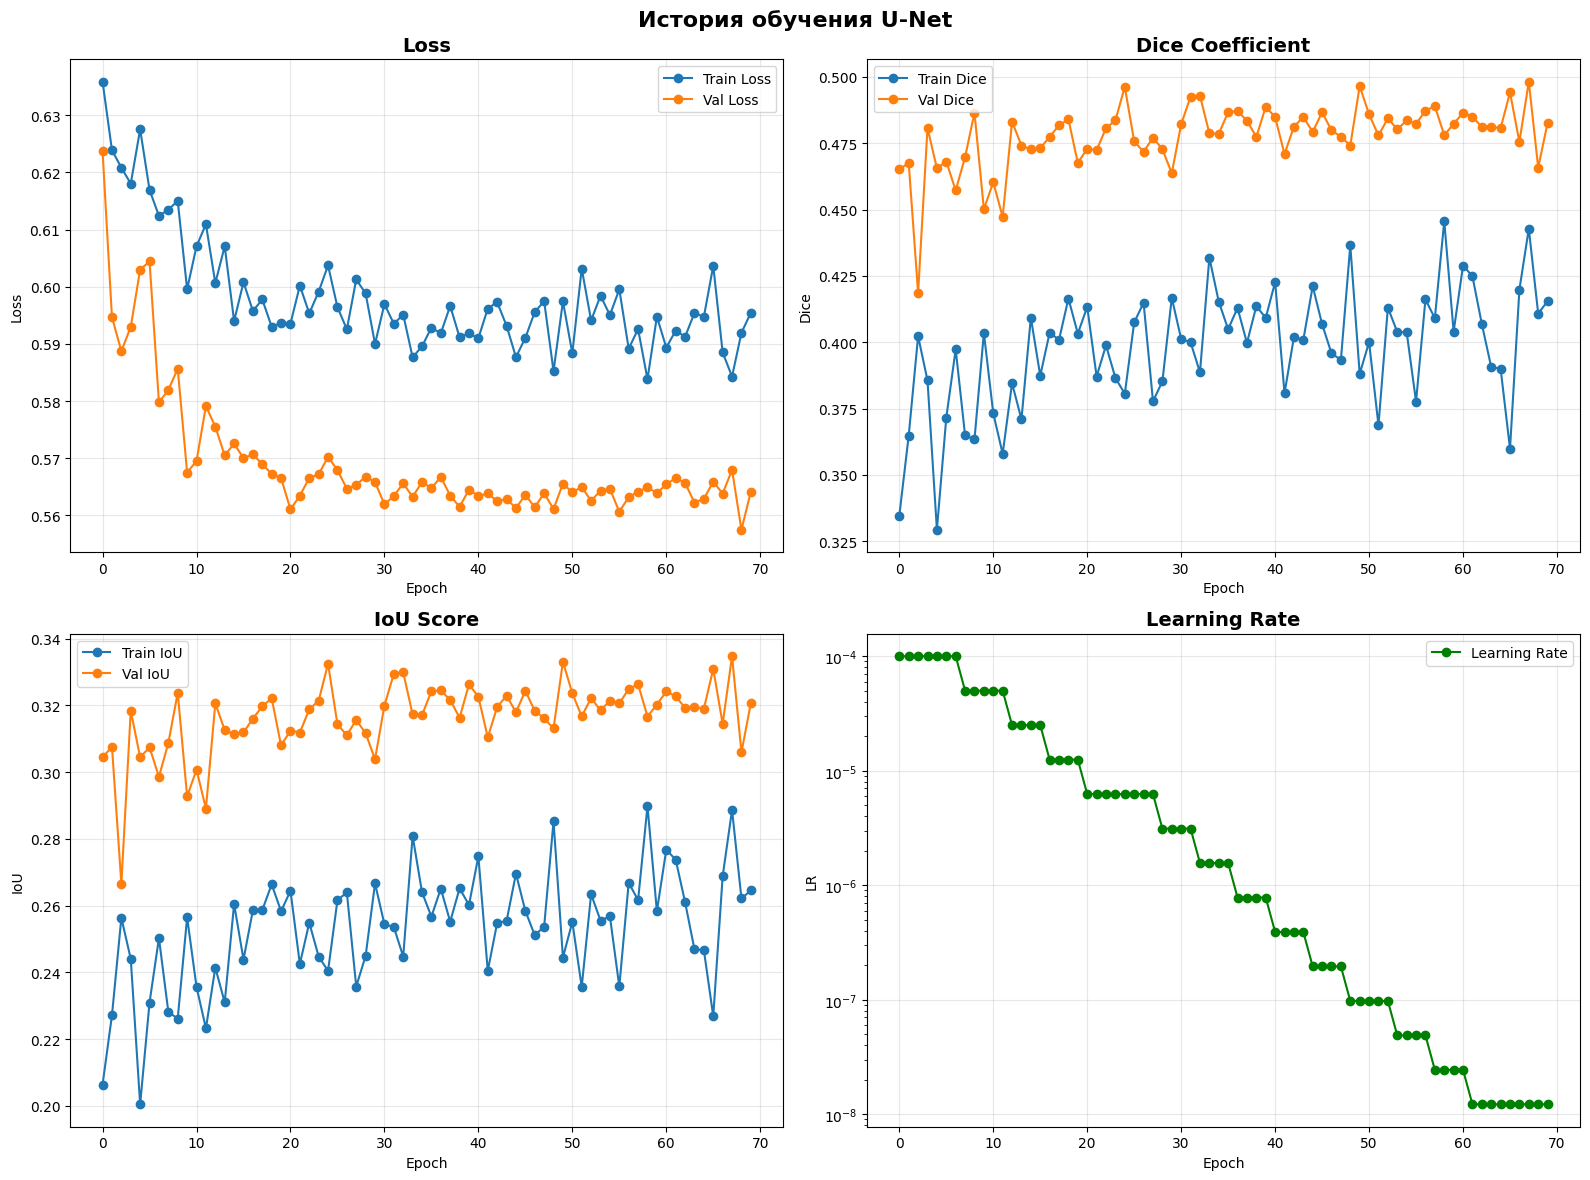

Train Loss: 0.5955
Val Loss: 0.5642
Train Dice: 0.4155
Val Dice: 0.4827
Train IoU: 0.2645
Val IoU: 0.3206
Val Accuracy: 0.9164


In [68]:
def plot_training_history(history):

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', marker='o')
    axes[0, 1].plot(history['val_dice'], label='Val Dice', marker='o')
    axes[0, 1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # IoU Score
    axes[1, 0].plot(history['train_iou'], label='Train IoU', marker='o')
    axes[1, 0].plot(history['val_iou'], label='Val IoU', marker='o')
    axes[1, 0].set_title('IoU Score', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 1].plot(history['lr'], label='Learning Rate', marker='o', color='green')
    axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('LR')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('История обучения U-Net', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


    print(f"Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"Train Dice: {history['train_dice'][-1]:.4f}")
    print(f"Val Dice: {history['val_dice'][-1]:.4f}")
    print(f"Train IoU: {history['train_iou'][-1]:.4f}")
    print(f"Val IoU: {history['val_iou'][-1]:.4f}")
    print(f"Val Accuracy: {history['val_acc'][-1]:.4f}")

plot_training_history(history)

In [33]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

def visualize_predictions(model, dataloader, device, num_samples=4):

    model.eval()
    model.to(device)
    images_list = []
    masks_list = []

    for images, masks in dataloader:
        images_list.append(images)
        masks_list.append(masks)
        if sum(len(b) for b in images_list) >= num_samples:
            break
    images = torch.cat(images_list, dim=0)[:num_samples]
    masks = torch.cat(masks_list, dim=0)[:num_samples]

    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        predictions = model(images)
        predictions = (predictions > 0.5).float()

    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if min(num_samples, len(images)) == 1:
        axes = axes.reshape(1, -1)

    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i, :,:].numpy()
        mask_pred = predictions[i, 0].numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное изображение', fontsize=12)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Истинная маска', fontsize=12)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('Предсказание', fontsize=12)
        axes[i, 2].axis('off')

        overlay = img.copy()
        overlay[mask_pred > 0.5] = [0, 1, 0]

        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Наложение', fontsize=12)
        axes[i, 3].axis('off')

        dice = dice_coefficient(predictions[i:i+1], masks[i:i+1])
        iou = iou_score(predictions[i:i+1], masks[i:i+1])


        axes[i, 3].text(
            0.5, -0.15,
            f'Dice: {dice:.4f}   |   IoU: {iou:.4f}',
            transform=axes[i, 3].transAxes,
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="none")
        )

    plt.suptitle('Предсказания модели U-Net', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

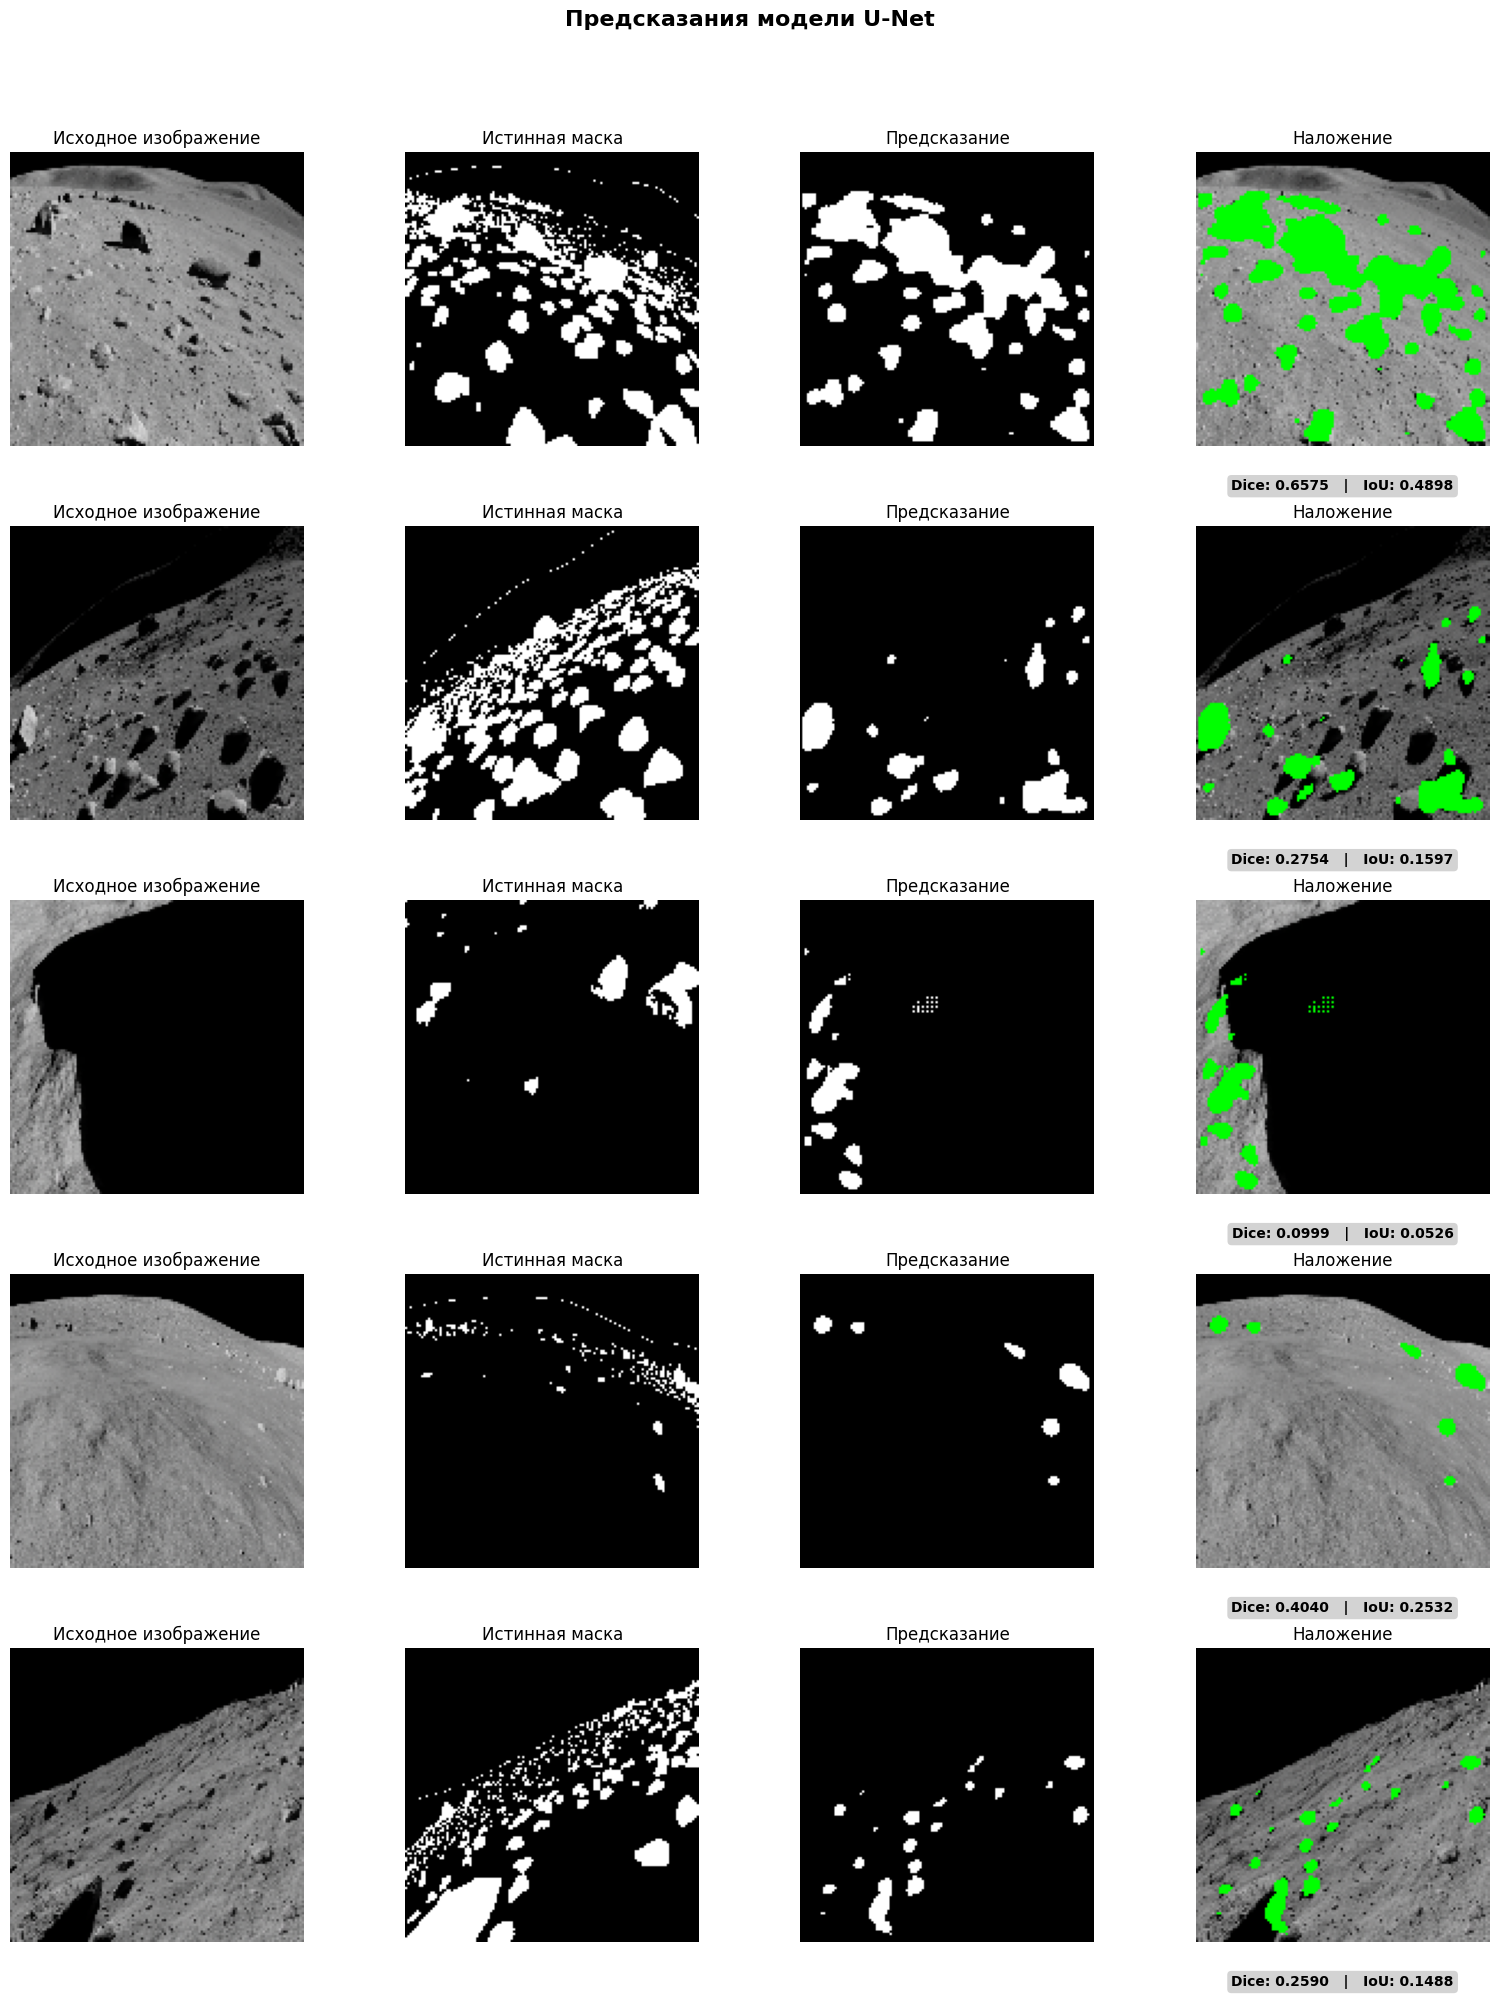

In [ ]:
visualize_predictions(model, val_loader, device, num_samples=5)

### Часть 3. U-Net с бэкбоном из классификатора
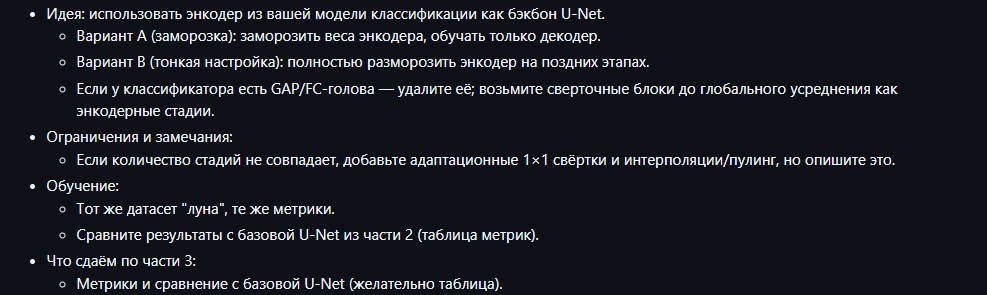

In [34]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x):
        return self.double_conv(x)

In [35]:
class ResNetUNet(nn.Module):
    def __init__(self, out_channels=1, freeze_encoder=False):
        super(ResNetUNet, self).__init__()

        # предобученный классификатор из ч.1
        classifier = ResNet(num_classes=10, num_blocks=[1,1,1,1])

        checkpoint = torch.load('resnet_classifier.pth', map_location='cpu')
        if 'model_state_dict' in checkpoint:
            classifier.load_state_dict(checkpoint['model_state_dict'])
        else:
            classifier.load_state_dict(checkpoint)

        # слои энкодера
        self.enc0 = nn.Sequential(
            classifier.conv1,
            classifier.bn1,
            classifier.gelu
        )  # [B, 32, 128, 128]

        self.enc1 = classifier.layer1  # [B, 32, 128, 128]
        self.enc2 = classifier.layer2  # [B, 64, 64, 64]
        self.enc3 = classifier.layer3  # [B, 128, 32, 32]
        self.enc4 = classifier.layer4  # [B, 256, 16, 16]

        # замораживаем энкодер
        if freeze_encoder:
            for enc in [self.enc0, self.enc1, self.enc2, self.enc3, self.enc4]:
                for param in enc.parameters():
                    param.requires_grad = False

        # декодер
        self.up4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(64 + 64, 64)

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(32 + 32, 32)

        self.up1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(32 + 32, 32)

        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # энкодер
        x0 = self.enc0(x)   # [B, 32, 128, 128]
        x1 = self.enc1(x0)  # [B, 32, 128, 128]
        x2 = self.enc2(x1)  # [B, 64, 64, 64]
        x3 = self.enc3(x2)  # [B, 128, 32, 32]
        x4 = self.enc4(x3)  # [B, 256, 16, 16]

        # декодер
        d4 = self.up4(x4)                  # [B, 128, 32, 32]
        d4 = torch.cat([d4, x3], dim=1)    # [B, 256, 32, 32]
        d4 = self.dec4(d4)                 # [B, 128, 32, 32]

        d3 = self.up3(d4)                  # [B, 64, 64, 64]
        d3 = torch.cat([d3, x2], dim=1)    # [B, 128, 64, 64]
        d3 = self.dec3(d3)                 # [B, 64, 64, 64]

        d2 = self.up2(d3)                  # [B, 32, 128, 128]
        d2 = torch.cat([d2, x1], dim=1)    # [B, 64, 128, 128]
        d2 = self.dec2(d2)                 # [B, 32, 128, 128]

        d1 = self.up1(d2)                  # [B, 32, 256, 256]
        # адаптируем x0 под размер d1
        x0_adapted = F.interpolate(x0, size=d1.shape[2:], mode='bilinear', align_corners=False)
        d1 = torch.cat([d1, x0_adapted], dim=1)  # [B, 64, 256, 256]
        d1 = self.dec1(d1)                 # [B, 32, 256, 256]

        # вернём к размеру 128x128
        d1 = F.interpolate(d1, size=(128, 128), mode='bilinear', align_corners=False)

        out = self.out_conv(d1)            # [B, 1, 128, 128]
        return out

### Вариант A (заморозка): заморозить веса энкодера, обучать только декодер.

In [36]:
# Вариант A: с замороженным энкодером
model_A = ResNetUNet(out_channels=1, freeze_encoder=True)

total_params = sum(p.numel() for p in model_A.parameters())
trainable_params = sum(p.numel() for p in model_A.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


Всего параметров: 2,012,609
Обучаемых параметров: 786,209


In [37]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)

    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }

    best_val_dice = 0.0

    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")

        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )
        if scheduler is not None:
            scheduler.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")
    print(f"Лучший Val Dice: {best_val_dice:.4f}")

    return history

In [39]:
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(model_A.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
)

history_unet_A = train_model(
    model=model_A,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=70,
    save_path='best_moon_unet_A.pth'
)

Эпоха 1/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.34it/s, loss=0.6342, dice=0.4472, iou=0.2880, acc=0.8607]



 Результаты эпохи 1:
  Train - Loss: 0.6338, Dice: 0.4292, IoU: 0.2792
  Val   - Loss: 0.6302, Dice: 0.4917, IoU: 0.3299, Acc: 0.8581
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4917
Эпоха 2/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s, loss=0.6229, dice=0.4557, iou=0.2951, acc=0.8783]



 Результаты эпохи 2:
  Train - Loss: 0.6299, Dice: 0.4352, IoU: 0.2864
  Val   - Loss: 0.6151, Dice: 0.4975, IoU: 0.3347, Acc: 0.8692
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4975
Эпоха 3/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.18it/s, loss=0.6196, dice=0.4551, iou=0.2946, acc=0.8767]



 Результаты эпохи 3:
  Train - Loss: 0.6297, Dice: 0.4165, IoU: 0.2701
  Val   - Loss: 0.6140, Dice: 0.4920, IoU: 0.3297, Acc: 0.8654
  LR: 0.000100
Эпоха 4/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.03it/s, loss=0.6135, dice=0.4616, iou=0.3000, acc=0.8868]



 Результаты эпохи 4:
  Train - Loss: 0.6226, Dice: 0.4270, IoU: 0.2778
  Val   - Loss: 0.6072, Dice: 0.5081, IoU: 0.3440, Acc: 0.8792
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.5081
Эпоха 5/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.32it/s, loss=0.6089, dice=0.4736, iou=0.3103, acc=0.8729]



 Результаты эпохи 5:
  Train - Loss: 0.6177, Dice: 0.4324, IoU: 0.2859
  Val   - Loss: 0.6114, Dice: 0.4954, IoU: 0.3316, Acc: 0.8650
  LR: 0.000100
Эпоха 6/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.68it/s, loss=0.6272, dice=0.4391, iou=0.2813, acc=0.8641]



 Результаты эпохи 6:
  Train - Loss: 0.6180, Dice: 0.4314, IoU: 0.2813
  Val   - Loss: 0.6220, Dice: 0.4855, IoU: 0.3252, Acc: 0.8545
  LR: 0.000100
Эпоха 7/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.04it/s, loss=0.6120, dice=0.4609, iou=0.2995, acc=0.8885]



 Результаты эпохи 7:
  Train - Loss: 0.6126, Dice: 0.4418, IoU: 0.2920
  Val   - Loss: 0.5992, Dice: 0.5066, IoU: 0.3427, Acc: 0.8788
  LR: 0.000100
Эпоха 8/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.78it/s, loss=0.6330, dice=0.4294, iou=0.2734, acc=0.8522]



 Результаты эпохи 8:
  Train - Loss: 0.6154, Dice: 0.4232, IoU: 0.2773
  Val   - Loss: 0.6289, Dice: 0.4699, IoU: 0.3106, Acc: 0.8405
  LR: 0.000050
Эпоха 9/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.24it/s, loss=0.6097, dice=0.4463, iou=0.2873, acc=0.8753]



 Результаты эпохи 9:
  Train - Loss: 0.6004, Dice: 0.4525, IoU: 0.2991
  Val   - Loss: 0.5988, Dice: 0.4909, IoU: 0.3288, Acc: 0.8642
  LR: 0.000050
Эпоха 10/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.76it/s, loss=0.6108, dice=0.4534, iou=0.2931, acc=0.8803]



 Результаты эпохи 10:
  Train - Loss: 0.6121, Dice: 0.4171, IoU: 0.2725
  Val   - Loss: 0.5989, Dice: 0.5076, IoU: 0.3437, Acc: 0.8786
  LR: 0.000050
Эпоха 11/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.69it/s, loss=0.6058, dice=0.4550, iou=0.2945, acc=0.8693]



 Результаты эпохи 11:
  Train - Loss: 0.6028, Dice: 0.4452, IoU: 0.2973
  Val   - Loss: 0.5987, Dice: 0.5002, IoU: 0.3376, Acc: 0.8641
  LR: 0.000050
Эпоха 12/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.29it/s, loss=0.6011, dice=0.4700, iou=0.3072, acc=0.8801]



 Результаты эпохи 12:
  Train - Loss: 0.5989, Dice: 0.4460, IoU: 0.2931
  Val   - Loss: 0.5923, Dice: 0.5027, IoU: 0.3400, Acc: 0.8666
  LR: 0.000025
Эпоха 13/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.33it/s, loss=0.6039, dice=0.4662, iou=0.3039, acc=0.8752]



 Результаты эпохи 13:
  Train - Loss: 0.5939, Dice: 0.4642, IoU: 0.3096
  Val   - Loss: 0.5939, Dice: 0.5064, IoU: 0.3433, Acc: 0.8682
  LR: 0.000025
Эпоха 14/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.14it/s, loss=0.5989, dice=0.4769, iou=0.3131, acc=0.8829]



 Результаты эпохи 14:
  Train - Loss: 0.5997, Dice: 0.4452, IoU: 0.2944
  Val   - Loss: 0.5912, Dice: 0.5140, IoU: 0.3497, Acc: 0.8749
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.5140
Эпоха 15/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.26it/s, loss=0.6035, dice=0.4507, iou=0.2909, acc=0.8752]



 Результаты эпохи 15:
  Train - Loss: 0.6019, Dice: 0.4390, IoU: 0.2904
  Val   - Loss: 0.5917, Dice: 0.5061, IoU: 0.3429, Acc: 0.8734
  LR: 0.000025
Эпоха 16/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.44it/s, loss=0.5991, dice=0.4640, iou=0.3021, acc=0.8763]



 Результаты эпохи 16:
  Train - Loss: 0.5994, Dice: 0.4352, IoU: 0.2848
  Val   - Loss: 0.5908, Dice: 0.5054, IoU: 0.3422, Acc: 0.8684
  LR: 0.000025
Эпоха 17/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.50it/s, loss=0.6007, dice=0.4621, iou=0.3005, acc=0.8742]



 Результаты эпохи 17:
  Train - Loss: 0.6004, Dice: 0.4325, IoU: 0.2818
  Val   - Loss: 0.5925, Dice: 0.4998, IoU: 0.3368, Acc: 0.8639
  LR: 0.000025
Эпоха 18/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.59it/s, loss=0.6021, dice=0.4872, iou=0.3220, acc=0.8828]



 Результаты эпохи 18:
  Train - Loss: 0.5885, Dice: 0.4712, IoU: 0.3133
  Val   - Loss: 0.5975, Dice: 0.5129, IoU: 0.3486, Acc: 0.8699
  LR: 0.000013
Эпоха 19/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.52it/s, loss=0.5925, dice=0.4855, iou=0.3205, acc=0.8891]



 Результаты эпохи 19:
  Train - Loss: 0.5887, Dice: 0.4685, IoU: 0.3107
  Val   - Loss: 0.5880, Dice: 0.5188, IoU: 0.3538, Acc: 0.8783
  LR: 0.000013
  Сохранена лучшая модель! Dice: 0.5188
Эпоха 20/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.49it/s, loss=0.5916, dice=0.4738, iou=0.3105, acc=0.8863]



 Результаты эпохи 20:
  Train - Loss: 0.6092, Dice: 0.3959, IoU: 0.2516
  Val   - Loss: 0.5857, Dice: 0.5090, IoU: 0.3451, Acc: 0.8739
  LR: 0.000013
Эпоха 21/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.15it/s, loss=0.5925, dice=0.4846, iou=0.3198, acc=0.8843]



 Результаты эпохи 21:
  Train - Loss: 0.6006, Dice: 0.4261, IoU: 0.2806
  Val   - Loss: 0.5902, Dice: 0.5121, IoU: 0.3480, Acc: 0.8710
  LR: 0.000013
Эпоха 22/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.14it/s, loss=0.5892, dice=0.4959, iou=0.3297, acc=0.8914]



 Результаты эпохи 22:
  Train - Loss: 0.5984, Dice: 0.4297, IoU: 0.2812
  Val   - Loss: 0.5872, Dice: 0.5223, IoU: 0.3572, Acc: 0.8788
  LR: 0.000013
  Сохранена лучшая модель! Dice: 0.5223
Эпоха 23/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.69it/s, loss=0.5938, dice=0.4961, iou=0.3299, acc=0.8903]



 Результаты эпохи 23:
  Train - Loss: 0.5924, Dice: 0.4522, IoU: 0.2973
  Val   - Loss: 0.5877, Dice: 0.5206, IoU: 0.3558, Acc: 0.8768
  LR: 0.000013
Эпоха 24/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.50it/s, loss=0.5952, dice=0.4808, iou=0.3165, acc=0.8827]



 Результаты эпохи 24:
  Train - Loss: 0.5845, Dice: 0.4774, IoU: 0.3180
  Val   - Loss: 0.5876, Dice: 0.5142, IoU: 0.3502, Acc: 0.8715
  LR: 0.000013
Эпоха 25/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.51it/s, loss=0.5981, dice=0.4784, iou=0.3144, acc=0.8769]



 Результаты эпохи 25:
  Train - Loss: 0.5917, Dice: 0.4521, IoU: 0.2982
  Val   - Loss: 0.5913, Dice: 0.5106, IoU: 0.3468, Acc: 0.8670
  LR: 0.000013
Эпоха 26/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.43it/s, loss=0.5881, dice=0.4939, iou=0.3279, acc=0.8873]



 Результаты эпохи 26:
  Train - Loss: 0.5848, Dice: 0.4667, IoU: 0.3112
  Val   - Loss: 0.5852, Dice: 0.5191, IoU: 0.3544, Acc: 0.8739
  LR: 0.000006
Эпоха 27/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s, loss=0.5923, dice=0.4898, iou=0.3243, acc=0.8861]



 Результаты эпохи 27:
  Train - Loss: 0.5948, Dice: 0.4341, IoU: 0.2828
  Val   - Loss: 0.5857, Dice: 0.5200, IoU: 0.3555, Acc: 0.8752
  LR: 0.000006
Эпоха 28/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.69it/s, loss=0.5940, dice=0.4717, iou=0.3087, acc=0.8756]



 Результаты эпохи 28:
  Train - Loss: 0.5833, Dice: 0.4724, IoU: 0.3152
  Val   - Loss: 0.5891, Dice: 0.5036, IoU: 0.3403, Acc: 0.8641
  LR: 0.000006
Эпоха 29/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.55it/s, loss=0.5889, dice=0.4920, iou=0.3263, acc=0.8876]



 Результаты эпохи 29:
  Train - Loss: 0.5871, Dice: 0.4562, IoU: 0.3029
  Val   - Loss: 0.5825, Dice: 0.5193, IoU: 0.3545, Acc: 0.8751
  LR: 0.000006
Эпоха 30/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.08it/s, loss=0.6026, dice=0.4718, iou=0.3088, acc=0.8692]



 Результаты эпохи 30:
  Train - Loss: 0.5936, Dice: 0.4493, IoU: 0.2960
  Val   - Loss: 0.5967, Dice: 0.5020, IoU: 0.3391, Acc: 0.8592
  LR: 0.000003
Эпоха 31/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.71it/s, loss=0.5963, dice=0.4871, iou=0.3219, acc=0.8830]



 Результаты эпохи 31:
  Train - Loss: 0.5911, Dice: 0.4456, IoU: 0.2945
  Val   - Loss: 0.5900, Dice: 0.5126, IoU: 0.3486, Acc: 0.8690
  LR: 0.000003
Эпоха 32/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.14it/s, loss=0.5919, dice=0.4831, iou=0.3184, acc=0.8876]



 Результаты эпохи 32:
  Train - Loss: 0.5956, Dice: 0.4333, IoU: 0.2806
  Val   - Loss: 0.5843, Dice: 0.5135, IoU: 0.3491, Acc: 0.8747
  LR: 0.000003
Эпоха 33/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.13it/s, loss=0.5892, dice=0.4829, iou=0.3183, acc=0.8849]



 Результаты эпохи 33:
  Train - Loss: 0.5913, Dice: 0.4418, IoU: 0.2936
  Val   - Loss: 0.5856, Dice: 0.5127, IoU: 0.3484, Acc: 0.8717
  LR: 0.000003
Эпоха 34/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.99it/s, loss=0.5884, dice=0.4822, iou=0.3177, acc=0.8878]



 Результаты эпохи 34:
  Train - Loss: 0.5969, Dice: 0.4322, IoU: 0.2823
  Val   - Loss: 0.5833, Dice: 0.5150, IoU: 0.3506, Acc: 0.8750
  LR: 0.000002
Эпоха 35/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.43it/s, loss=0.5849, dice=0.4914, iou=0.3257, acc=0.8916]



 Результаты эпохи 35:
  Train - Loss: 0.5889, Dice: 0.4473, IoU: 0.2948
  Val   - Loss: 0.5800, Dice: 0.5230, IoU: 0.3580, Acc: 0.8793
  LR: 0.000002
  Сохранена лучшая модель! Dice: 0.5230
Эпоха 36/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.37it/s, loss=0.5843, dice=0.4879, iou=0.3227, acc=0.8933]



 Результаты эпохи 36:
  Train - Loss: 0.5801, Dice: 0.4816, IoU: 0.3217
  Val   - Loss: 0.5778, Dice: 0.5215, IoU: 0.3563, Acc: 0.8813
  LR: 0.000002
Эпоха 37/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.49it/s, loss=0.5775, dice=0.4927, iou=0.3269, acc=0.8990]



 Результаты эпохи 37:
  Train - Loss: 0.5900, Dice: 0.4600, IoU: 0.3094
  Val   - Loss: 0.5719, Dice: 0.5258, IoU: 0.3601, Acc: 0.8864
  LR: 0.000002
  Сохранена лучшая модель! Dice: 0.5258
Эпоха 38/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.38it/s, loss=0.5893, dice=0.4839, iou=0.3192, acc=0.8879]



 Результаты эпохи 38:
  Train - Loss: 0.5973, Dice: 0.4342, IoU: 0.2849
  Val   - Loss: 0.5841, Dice: 0.5164, IoU: 0.3517, Acc: 0.8758
  LR: 0.000002
Эпоха 39/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.63it/s, loss=0.5900, dice=0.4770, iou=0.3132, acc=0.8842]



 Результаты эпохи 39:
  Train - Loss: 0.5926, Dice: 0.4528, IoU: 0.2995
  Val   - Loss: 0.5832, Dice: 0.5142, IoU: 0.3498, Acc: 0.8744
  LR: 0.000002
Эпоха 40/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.73it/s, loss=0.5907, dice=0.4791, iou=0.3151, acc=0.8813]



 Результаты эпохи 40:
  Train - Loss: 0.5821, Dice: 0.4738, IoU: 0.3140
  Val   - Loss: 0.5848, Dice: 0.5120, IoU: 0.3479, Acc: 0.8709
  LR: 0.000002
Эпоха 41/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.30it/s, loss=0.5942, dice=0.4794, iou=0.3152, acc=0.8813]



 Результаты эпохи 41:
  Train - Loss: 0.5970, Dice: 0.4252, IoU: 0.2781
  Val   - Loss: 0.5895, Dice: 0.5120, IoU: 0.3478, Acc: 0.8702
  LR: 0.000001
Эпоха 42/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.12it/s, loss=0.5871, dice=0.4858, iou=0.3208, acc=0.8913]



 Результаты эпохи 42:
  Train - Loss: 0.5914, Dice: 0.4498, IoU: 0.2933
  Val   - Loss: 0.5799, Dice: 0.5210, IoU: 0.3560, Acc: 0.8803
  LR: 0.000001
Эпоха 43/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s, loss=0.5843, dice=0.4801, iou=0.3159, acc=0.8879]



 Результаты эпохи 43:
  Train - Loss: 0.5881, Dice: 0.4561, IoU: 0.3019
  Val   - Loss: 0.5796, Dice: 0.5146, IoU: 0.3501, Acc: 0.8762
  LR: 0.000001
Эпоха 44/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s, loss=0.5847, dice=0.4907, iou=0.3251, acc=0.8912]



 Результаты эпохи 44:
  Train - Loss: 0.5823, Dice: 0.4691, IoU: 0.3134
  Val   - Loss: 0.5802, Dice: 0.5217, IoU: 0.3566, Acc: 0.8793
  LR: 0.000001
Эпоха 45/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.22it/s, loss=0.5851, dice=0.4842, iou=0.3194, acc=0.8893]



 Результаты эпохи 45:
  Train - Loss: 0.5904, Dice: 0.4448, IoU: 0.2966
  Val   - Loss: 0.5804, Dice: 0.5175, IoU: 0.3528, Acc: 0.8777
  LR: 0.000000
Эпоха 46/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.06it/s, loss=0.5944, dice=0.4741, iou=0.3107, acc=0.8829]



 Результаты эпохи 46:
  Train - Loss: 0.6038, Dice: 0.4181, IoU: 0.2718
  Val   - Loss: 0.5901, Dice: 0.5108, IoU: 0.3465, Acc: 0.8730
  LR: 0.000000
Эпоха 47/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.76it/s, loss=0.5846, dice=0.4875, iou=0.3223, acc=0.8870]



 Результаты эпохи 47:
  Train - Loss: 0.5914, Dice: 0.4397, IoU: 0.2933
  Val   - Loss: 0.5820, Dice: 0.5176, IoU: 0.3528, Acc: 0.8751
  LR: 0.000000
Эпоха 48/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.60it/s, loss=0.5811, dice=0.4872, iou=0.3221, acc=0.8901]



 Результаты эпохи 48:
  Train - Loss: 0.5848, Dice: 0.4706, IoU: 0.3128
  Val   - Loss: 0.5757, Dice: 0.5191, IoU: 0.3541, Acc: 0.8783
  LR: 0.000000
Эпоха 49/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.07it/s, loss=0.5844, dice=0.4890, iou=0.3236, acc=0.8905]



 Результаты эпохи 49:
  Train - Loss: 0.5867, Dice: 0.4567, IoU: 0.3035
  Val   - Loss: 0.5788, Dice: 0.5209, IoU: 0.3559, Acc: 0.8791
  LR: 0.000000
Эпоха 50/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.69it/s, loss=0.5938, dice=0.4778, iou=0.3139, acc=0.8824]



 Результаты эпохи 50:
  Train - Loss: 0.5796, Dice: 0.4752, IoU: 0.3208
  Val   - Loss: 0.5870, Dice: 0.5137, IoU: 0.3496, Acc: 0.8725
  LR: 0.000000
Эпоха 51/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.78it/s, loss=0.5868, dice=0.4874, iou=0.3223, acc=0.8883]



 Результаты эпохи 51:
  Train - Loss: 0.5857, Dice: 0.4611, IoU: 0.3051
  Val   - Loss: 0.5819, Dice: 0.5186, IoU: 0.3540, Acc: 0.8764
  LR: 0.000000
Эпоха 52/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.48it/s, loss=0.5909, dice=0.4871, iou=0.3219, acc=0.8872]



 Результаты эпохи 52:
  Train - Loss: 0.5837, Dice: 0.4686, IoU: 0.3121
  Val   - Loss: 0.5846, Dice: 0.5203, IoU: 0.3556, Acc: 0.8770
  LR: 0.000000
Эпоха 53/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.09it/s, loss=0.5912, dice=0.4821, iou=0.3177, acc=0.8811]



 Результаты эпохи 53:
  Train - Loss: 0.5934, Dice: 0.4392, IoU: 0.2924
  Val   - Loss: 0.5872, Dice: 0.5126, IoU: 0.3485, Acc: 0.8699
  LR: 0.000000
Эпоха 54/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.70it/s, loss=0.5919, dice=0.4789, iou=0.3148, acc=0.8786]



 Результаты эпохи 54:
  Train - Loss: 0.5938, Dice: 0.4362, IoU: 0.2906
  Val   - Loss: 0.5898, Dice: 0.5081, IoU: 0.3444, Acc: 0.8663
  LR: 0.000000
Эпоха 55/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.65it/s, loss=0.5932, dice=0.4747, iou=0.3112, acc=0.8750]



 Результаты эпохи 55:
  Train - Loss: 0.6016, Dice: 0.4065, IoU: 0.2631
  Val   - Loss: 0.5907, Dice: 0.5064, IoU: 0.3430, Acc: 0.8645
  LR: 0.000000
Эпоха 56/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.78it/s, loss=0.5943, dice=0.4776, iou=0.3137, acc=0.8755]



 Результаты эпохи 56:
  Train - Loss: 0.5904, Dice: 0.4501, IoU: 0.2951
  Val   - Loss: 0.5906, Dice: 0.5090, IoU: 0.3453, Acc: 0.8655
  LR: 0.000000
Эпоха 57/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.38it/s, loss=0.5927, dice=0.4781, iou=0.3141, acc=0.8815]



 Результаты эпохи 57:
  Train - Loss: 0.5966, Dice: 0.4405, IoU: 0.2927
  Val   - Loss: 0.5872, Dice: 0.5112, IoU: 0.3473, Acc: 0.8707
  LR: 0.000000
Эпоха 58/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.51it/s, loss=0.5986, dice=0.4769, iou=0.3131, acc=0.8731]



 Результаты эпохи 58:
  Train - Loss: 0.5868, Dice: 0.4592, IoU: 0.3066
  Val   - Loss: 0.5958, Dice: 0.5027, IoU: 0.3398, Acc: 0.8601
  LR: 0.000000
Эпоха 59/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.27it/s, loss=0.5924, dice=0.4851, iou=0.3202, acc=0.8840]



 Результаты эпохи 59:
  Train - Loss: 0.5953, Dice: 0.4305, IoU: 0.2799
  Val   - Loss: 0.5888, Dice: 0.5122, IoU: 0.3481, Acc: 0.8704
  LR: 0.000000
Эпоха 60/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.56it/s, loss=0.5947, dice=0.4781, iou=0.3141, acc=0.8812]



 Результаты эпохи 60:
  Train - Loss: 0.5984, Dice: 0.4289, IoU: 0.2807
  Val   - Loss: 0.5884, Dice: 0.5130, IoU: 0.3490, Acc: 0.8720
  LR: 0.000000
Эпоха 61/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.51it/s, loss=0.5875, dice=0.4789, iou=0.3149, acc=0.8859]



 Результаты эпохи 61:
  Train - Loss: 0.5881, Dice: 0.4603, IoU: 0.3053
  Val   - Loss: 0.5832, Dice: 0.5162, IoU: 0.3516, Acc: 0.8758
  LR: 0.000000
Эпоха 62/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s, loss=0.5841, dice=0.4894, iou=0.3239, acc=0.8912]



 Результаты эпохи 62:
  Train - Loss: 0.5860, Dice: 0.4622, IoU: 0.3045
  Val   - Loss: 0.5785, Dice: 0.5210, IoU: 0.3561, Acc: 0.8791
  LR: 0.000000
Эпоха 63/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.01it/s, loss=0.5888, dice=0.4873, iou=0.3222, acc=0.8846]



 Результаты эпохи 63:
  Train - Loss: 0.5941, Dice: 0.4537, IoU: 0.3042
  Val   - Loss: 0.5859, Dice: 0.5155, IoU: 0.3510, Acc: 0.8723
  LR: 0.000000
Эпоха 64/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.50it/s, loss=0.5872, dice=0.4866, iou=0.3216, acc=0.8855]



 Результаты эпохи 64:
  Train - Loss: 0.5931, Dice: 0.4403, IoU: 0.2895
  Val   - Loss: 0.5842, Dice: 0.5146, IoU: 0.3503, Acc: 0.8724
  LR: 0.000000
Эпоха 65/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.33it/s, loss=0.5959, dice=0.4763, iou=0.3126, acc=0.8766]



 Результаты эпохи 65:
  Train - Loss: 0.5910, Dice: 0.4522, IoU: 0.2992
  Val   - Loss: 0.5926, Dice: 0.5053, IoU: 0.3419, Acc: 0.8645
  LR: 0.000000
Эпоха 66/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.91it/s, loss=0.6016, dice=0.4735, iou=0.3102, acc=0.8768]



 Результаты эпохи 66:
  Train - Loss: 0.5853, Dice: 0.4682, IoU: 0.3097
  Val   - Loss: 0.5934, Dice: 0.5044, IoU: 0.3411, Acc: 0.8650
  LR: 0.000000
Эпоха 67/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.23it/s, loss=0.5927, dice=0.4804, iou=0.3161, acc=0.8825]



 Результаты эпохи 67:
  Train - Loss: 0.5845, Dice: 0.4654, IoU: 0.3099
  Val   - Loss: 0.5869, Dice: 0.5120, IoU: 0.3479, Acc: 0.8711
  LR: 0.000000
Эпоха 68/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.09it/s, loss=0.5944, dice=0.4693, iou=0.3066, acc=0.8771]



 Результаты эпохи 68:
  Train - Loss: 0.5825, Dice: 0.4653, IoU: 0.3112
  Val   - Loss: 0.5886, Dice: 0.5070, IoU: 0.3435, Acc: 0.8681
  LR: 0.000000
Эпоха 69/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.31it/s, loss=0.5899, dice=0.4873, iou=0.3221, acc=0.8858]



 Результаты эпохи 69:
  Train - Loss: 0.5942, Dice: 0.4339, IoU: 0.2875
  Val   - Loss: 0.5854, Dice: 0.5180, IoU: 0.3534, Acc: 0.8746
  LR: 0.000000
Эпоха 70/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.74it/s, loss=0.5879, dice=0.4842, iou=0.3194, acc=0.8879]


 Результаты эпохи 70:
  Train - Loss: 0.5945, Dice: 0.4282, IoU: 0.2789
  Val   - Loss: 0.5821, Dice: 0.5150, IoU: 0.3506, Acc: 0.8750
  LR: 0.000000
Лучший Val Dice: 0.5258


### Вариант B - без заморозки

In [40]:
# Вариант B - без заморозки (fine-tuning)
model_B = ResNetUNet(out_channels=1, freeze_encoder=False)

total_params = sum(p.numel() for p in model_B.parameters())
trainable_params = sum(p.numel() for p in model_B.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


Всего параметров: 2,012,609
Обучаемых параметров: 2,012,609


In [41]:
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(model_B.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
)

history_unet_B = train_model(
    model=model_B,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=70,
    save_path='best_moon_unet_B.pth'
)

Эпоха 1/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.88it/s, loss=0.6949, dice=0.1923, iou=0.1063, acc=0.9128]



 Результаты эпохи 1:
  Train - Loss: 0.7069, Dice: 0.2814, IoU: 0.1666
  Val   - Loss: 0.6952, Dice: 0.2226, IoU: 0.1254, Acc: 0.9007
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.2226
Эпоха 2/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.67it/s, loss=0.6478, dice=0.4297, iou=0.2736, acc=0.8785]



 Результаты эпохи 2:
  Train - Loss: 0.6850, Dice: 0.3360, IoU: 0.2082
  Val   - Loss: 0.6494, Dice: 0.4647, IoU: 0.3042, Acc: 0.8656
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4647
Эпоха 3/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.45it/s, loss=0.6436, dice=0.4197, iou=0.2656, acc=0.8551]



 Результаты эпохи 3:
  Train - Loss: 0.6586, Dice: 0.3818, IoU: 0.2414
  Val   - Loss: 0.6578, Dice: 0.4490, IoU: 0.2924, Acc: 0.8330
  LR: 0.000100
Эпоха 4/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.69it/s, loss=0.6078, dice=0.4700, iou=0.3072, acc=0.9055]



 Результаты эпохи 4:
  Train - Loss: 0.6372, Dice: 0.4302, IoU: 0.2780
  Val   - Loss: 0.6140, Dice: 0.5003, IoU: 0.3362, Acc: 0.8870
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.5003
Эпоха 5/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.14it/s, loss=0.6091, dice=0.4495, iou=0.2899, acc=0.8906]



 Результаты эпохи 5:
  Train - Loss: 0.6246, Dice: 0.4320, IoU: 0.2810
  Val   - Loss: 0.6172, Dice: 0.5007, IoU: 0.3382, Acc: 0.8800
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.5007
Эпоха 6/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.66it/s, loss=0.5904, dice=0.4682, iou=0.3057, acc=0.9137]



 Результаты эпохи 6:
  Train - Loss: 0.6221, Dice: 0.4105, IoU: 0.2633
  Val   - Loss: 0.5935, Dice: 0.5104, IoU: 0.3448, Acc: 0.8991
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.5104
Эпоха 7/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.73it/s, loss=0.5866, dice=0.4822, iou=0.3177, acc=0.9056]



 Результаты эпохи 7:
  Train - Loss: 0.6234, Dice: 0.3961, IoU: 0.2527
  Val   - Loss: 0.5917, Dice: 0.5150, IoU: 0.3497, Acc: 0.8884
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.5150
Эпоха 8/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.61it/s, loss=0.5805, dice=0.4703, iou=0.3075, acc=0.9119]



 Результаты эпохи 8:
  Train - Loss: 0.6048, Dice: 0.4348, IoU: 0.2850
  Val   - Loss: 0.5778, Dice: 0.5148, IoU: 0.3492, Acc: 0.8992
  LR: 0.000100
Эпоха 9/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.74it/s, loss=0.5789, dice=0.4924, iou=0.3266, acc=0.9096]



 Результаты эпохи 9:
  Train - Loss: 0.5983, Dice: 0.4421, IoU: 0.2899
  Val   - Loss: 0.5763, Dice: 0.5309, IoU: 0.3649, Acc: 0.8952
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.5309
Эпоха 10/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.64it/s, loss=0.5698, dice=0.4841, iou=0.3193, acc=0.9110]



 Результаты эпохи 10:
  Train - Loss: 0.5960, Dice: 0.4301, IoU: 0.2809
  Val   - Loss: 0.5777, Dice: 0.5251, IoU: 0.3603, Acc: 0.8943
  LR: 0.000100
Эпоха 11/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.87it/s, loss=0.5850, dice=0.4798, iou=0.3156, acc=0.9009]



 Результаты эпохи 11:
  Train - Loss: 0.5887, Dice: 0.4434, IoU: 0.2898
  Val   - Loss: 0.5835, Dice: 0.5225, IoU: 0.3571, Acc: 0.8887
  LR: 0.000100
Эпоха 12/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.43it/s, loss=0.5590, dice=0.4980, iou=0.3316, acc=0.9104]



 Результаты эпохи 12:
  Train - Loss: 0.5903, Dice: 0.4278, IoU: 0.2795
  Val   - Loss: 0.5657, Dice: 0.5270, IoU: 0.3610, Acc: 0.8920
  LR: 0.000100
Эпоха 13/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.63it/s, loss=0.5643, dice=0.4977, iou=0.3313, acc=0.9196]



 Результаты эпохи 13:
  Train - Loss: 0.5827, Dice: 0.4460, IoU: 0.2918
  Val   - Loss: 0.5525, Dice: 0.5364, IoU: 0.3694, Acc: 0.9055
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.5364
Эпоха 14/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.55it/s, loss=0.5533, dice=0.4915, iou=0.3258, acc=0.9158]



 Результаты эпохи 14:
  Train - Loss: 0.5842, Dice: 0.4228, IoU: 0.2737
  Val   - Loss: 0.5560, Dice: 0.5275, IoU: 0.3613, Acc: 0.9027
  LR: 0.000100
Эпоха 15/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s, loss=0.5591, dice=0.5002, iou=0.3335, acc=0.9068]



 Результаты эпохи 15:
  Train - Loss: 0.5702, Dice: 0.4578, IoU: 0.3039
  Val   - Loss: 0.5657, Dice: 0.5298, IoU: 0.3639, Acc: 0.8902
  LR: 0.000100
Эпоха 16/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.78it/s, loss=0.5534, dice=0.5266, iou=0.3574, acc=0.9214]



 Результаты эпохи 16:
  Train - Loss: 0.5646, Dice: 0.4788, IoU: 0.3183
  Val   - Loss: 0.5485, Dice: 0.5528, IoU: 0.3860, Acc: 0.9053
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.5528
Эпоха 17/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.11it/s, loss=0.5462, dice=0.5026, iou=0.3356, acc=0.9231]



 Результаты эпохи 17:
  Train - Loss: 0.5668, Dice: 0.4484, IoU: 0.2976
  Val   - Loss: 0.5352, Dice: 0.5482, IoU: 0.3811, Acc: 0.9093
  LR: 0.000100
Эпоха 18/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.77it/s, loss=0.5349, dice=0.5035, iou=0.3364, acc=0.9154]



 Результаты эпохи 18:
  Train - Loss: 0.5618, Dice: 0.4658, IoU: 0.3103
  Val   - Loss: 0.5408, Dice: 0.5402, IoU: 0.3737, Acc: 0.9015
  LR: 0.000100
Эпоха 19/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.88it/s, loss=0.5310, dice=0.5179, iou=0.3495, acc=0.9208]



 Результаты эпохи 19:
  Train - Loss: 0.5649, Dice: 0.4408, IoU: 0.2885
  Val   - Loss: 0.5302, Dice: 0.5512, IoU: 0.3842, Acc: 0.9054
  LR: 0.000100
Эпоха 20/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s, loss=0.5354, dice=0.5077, iou=0.3402, acc=0.9172]



 Результаты эпохи 20:
  Train - Loss: 0.5668, Dice: 0.4315, IoU: 0.2834
  Val   - Loss: 0.5401, Dice: 0.5363, IoU: 0.3695, Acc: 0.8998
  LR: 0.000050
Эпоха 21/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.87it/s, loss=0.5498, dice=0.4976, iou=0.3312, acc=0.9056]



 Результаты эпохи 21:
  Train - Loss: 0.5548, Dice: 0.4648, IoU: 0.3094
  Val   - Loss: 0.5533, Dice: 0.5301, IoU: 0.3648, Acc: 0.8875
  LR: 0.000050
Эпоха 22/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.72it/s, loss=0.5361, dice=0.5063, iou=0.3390, acc=0.9135]



 Результаты эпохи 22:
  Train - Loss: 0.5531, Dice: 0.4604, IoU: 0.3068
  Val   - Loss: 0.5356, Dice: 0.5461, IoU: 0.3805, Acc: 0.8999
  LR: 0.000050
Эпоха 23/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.95it/s, loss=0.5245, dice=0.5117, iou=0.3439, acc=0.9172]



 Результаты эпохи 23:
  Train - Loss: 0.5462, Dice: 0.4750, IoU: 0.3182
  Val   - Loss: 0.5272, Dice: 0.5475, IoU: 0.3815, Acc: 0.9017
  LR: 0.000050
Эпоха 24/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.73it/s, loss=0.5250, dice=0.5216, iou=0.3528, acc=0.9179]



 Результаты эпохи 24:
  Train - Loss: 0.5468, Dice: 0.4749, IoU: 0.3214
  Val   - Loss: 0.5288, Dice: 0.5505, IoU: 0.3842, Acc: 0.9007
  LR: 0.000025
Эпоха 25/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.83it/s, loss=0.5248, dice=0.5228, iou=0.3539, acc=0.9168]



 Результаты эпохи 25:
  Train - Loss: 0.5422, Dice: 0.4775, IoU: 0.3202
  Val   - Loss: 0.5276, Dice: 0.5472, IoU: 0.3807, Acc: 0.8981
  LR: 0.000025
Эпоха 26/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.64it/s, loss=0.5256, dice=0.5231, iou=0.3542, acc=0.9191]



 Результаты эпохи 26:
  Train - Loss: 0.5540, Dice: 0.4392, IoU: 0.2893
  Val   - Loss: 0.5252, Dice: 0.5525, IoU: 0.3860, Acc: 0.9019
  LR: 0.000025
Эпоха 27/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.78it/s, loss=0.5201, dice=0.5212, iou=0.3524, acc=0.9181]



 Результаты эпохи 27:
  Train - Loss: 0.5403, Dice: 0.4838, IoU: 0.3246
  Val   - Loss: 0.5237, Dice: 0.5496, IoU: 0.3830, Acc: 0.9010
  LR: 0.000025
Эпоха 28/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.91it/s, loss=0.5256, dice=0.5136, iou=0.3455, acc=0.9124]



 Результаты эпохи 28:
  Train - Loss: 0.5562, Dice: 0.4330, IoU: 0.2813
  Val   - Loss: 0.5325, Dice: 0.5412, IoU: 0.3753, Acc: 0.8941
  LR: 0.000013
Эпоха 29/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.24it/s, loss=0.5243, dice=0.5282, iou=0.3589, acc=0.9166]



 Результаты эпохи 29:
  Train - Loss: 0.5351, Dice: 0.4891, IoU: 0.3325
  Val   - Loss: 0.5282, Dice: 0.5512, IoU: 0.3849, Acc: 0.8984
  LR: 0.000013
Эпоха 30/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.23it/s, loss=0.5196, dice=0.5250, iou=0.3560, acc=0.9205]



 Результаты эпохи 30:
  Train - Loss: 0.5513, Dice: 0.4468, IoU: 0.2951
  Val   - Loss: 0.5199, Dice: 0.5540, IoU: 0.3874, Acc: 0.9041
  LR: 0.000013
  Сохранена лучшая модель! Dice: 0.5540
Эпоха 31/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.11it/s, loss=0.5173, dice=0.5253, iou=0.3562, acc=0.9217]



 Результаты эпохи 31:
  Train - Loss: 0.5461, Dice: 0.4524, IoU: 0.3047
  Val   - Loss: 0.5191, Dice: 0.5558, IoU: 0.3889, Acc: 0.9060
  LR: 0.000013
  Сохранена лучшая модель! Dice: 0.5558
Эпоха 32/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.07it/s, loss=0.5207, dice=0.5212, iou=0.3524, acc=0.9200]



 Результаты эпохи 32:
  Train - Loss: 0.5406, Dice: 0.4727, IoU: 0.3174
  Val   - Loss: 0.5200, Dice: 0.5545, IoU: 0.3879, Acc: 0.9049
  LR: 0.000013
Эпоха 33/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.31it/s, loss=0.5159, dice=0.5237, iou=0.3548, acc=0.9193]



 Результаты эпохи 33:
  Train - Loss: 0.5378, Dice: 0.4796, IoU: 0.3237
  Val   - Loss: 0.5169, Dice: 0.5560, IoU: 0.3900, Acc: 0.9033
  LR: 0.000013
  Сохранена лучшая модель! Dice: 0.5560
Эпоха 34/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.30it/s, loss=0.5226, dice=0.5201, iou=0.3514, acc=0.9120]



 Результаты эпохи 34:
  Train - Loss: 0.5426, Dice: 0.4671, IoU: 0.3134
  Val   - Loss: 0.5226, Dice: 0.5478, IoU: 0.3825, Acc: 0.8937
  LR: 0.000013
Эпоха 35/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.67it/s, loss=0.5248, dice=0.5185, iou=0.3500, acc=0.9140]



 Результаты эпохи 35:
  Train - Loss: 0.5341, Dice: 0.4849, IoU: 0.3263
  Val   - Loss: 0.5226, Dice: 0.5526, IoU: 0.3874, Acc: 0.8988
  LR: 0.000013
Эпоха 36/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.75it/s, loss=0.5209, dice=0.5298, iou=0.3604, acc=0.9178]



 Результаты эпохи 36:
  Train - Loss: 0.5407, Dice: 0.4664, IoU: 0.3129
  Val   - Loss: 0.5195, Dice: 0.5584, IoU: 0.3925, Acc: 0.9026
  LR: 0.000013
  Сохранена лучшая модель! Dice: 0.5584
Эпоха 37/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.66it/s, loss=0.5202, dice=0.5224, iou=0.3536, acc=0.9161]



 Результаты эпохи 37:
  Train - Loss: 0.5455, Dice: 0.4520, IoU: 0.2994
  Val   - Loss: 0.5197, Dice: 0.5545, IoU: 0.3884, Acc: 0.9017
  LR: 0.000013
Эпоха 38/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s, loss=0.5132, dice=0.5275, iou=0.3583, acc=0.9197]



 Результаты эпохи 38:
  Train - Loss: 0.5341, Dice: 0.4795, IoU: 0.3239
  Val   - Loss: 0.5132, Dice: 0.5623, IoU: 0.3961, Acc: 0.9063
  LR: 0.000013
  Сохранена лучшая модель! Dice: 0.5623
Эпоха 39/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.74it/s, loss=0.5105, dice=0.5246, iou=0.3556, acc=0.9195]



 Результаты эпохи 39:
  Train - Loss: 0.5536, Dice: 0.4251, IoU: 0.2775
  Val   - Loss: 0.5102, Dice: 0.5577, IoU: 0.3914, Acc: 0.9049
  LR: 0.000013
Эпоха 40/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.78it/s, loss=0.5169, dice=0.5219, iou=0.3531, acc=0.9165]



 Результаты эпохи 40:
  Train - Loss: 0.5319, Dice: 0.4896, IoU: 0.3322
  Val   - Loss: 0.5144, Dice: 0.5569, IoU: 0.3908, Acc: 0.9021
  LR: 0.000013
Эпоха 41/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.21it/s, loss=0.5187, dice=0.5235, iou=0.3546, acc=0.9166]



 Результаты эпохи 41:
  Train - Loss: 0.5337, Dice: 0.4875, IoU: 0.3294
  Val   - Loss: 0.5157, Dice: 0.5580, IoU: 0.3918, Acc: 0.9026
  LR: 0.000013
Эпоха 42/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.21it/s, loss=0.5165, dice=0.5249, iou=0.3559, acc=0.9163]



 Результаты эпохи 42:
  Train - Loss: 0.5284, Dice: 0.4986, IoU: 0.3364
  Val   - Loss: 0.5169, Dice: 0.5582, IoU: 0.3921, Acc: 0.9018
  LR: 0.000006
Эпоха 43/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.05it/s, loss=0.5218, dice=0.5229, iou=0.3540, acc=0.9142]



 Результаты эпохи 43:
  Train - Loss: 0.5357, Dice: 0.4753, IoU: 0.3166
  Val   - Loss: 0.5195, Dice: 0.5577, IoU: 0.3916, Acc: 0.9005
  LR: 0.000006
Эпоха 44/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.18it/s, loss=0.5165, dice=0.5171, iou=0.3487, acc=0.9149]



 Результаты эпохи 44:
  Train - Loss: 0.5294, Dice: 0.4849, IoU: 0.3256
  Val   - Loss: 0.5133, Dice: 0.5562, IoU: 0.3902, Acc: 0.9020
  LR: 0.000006
Эпоха 45/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.15it/s, loss=0.5259, dice=0.5162, iou=0.3479, acc=0.9108]



 Результаты эпохи 45:
  Train - Loss: 0.5218, Dice: 0.5039, IoU: 0.3427
  Val   - Loss: 0.5207, Dice: 0.5533, IoU: 0.3878, Acc: 0.8976
  LR: 0.000006
Эпоха 46/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.27it/s, loss=0.5191, dice=0.5177, iou=0.3493, acc=0.9135]



 Результаты эпохи 46:
  Train - Loss: 0.5426, Dice: 0.4531, IoU: 0.2987
  Val   - Loss: 0.5169, Dice: 0.5543, IoU: 0.3885, Acc: 0.8998
  LR: 0.000003
Эпоха 47/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.74it/s, loss=0.5179, dice=0.5219, iou=0.3531, acc=0.9140]



 Результаты эпохи 47:
  Train - Loss: 0.5313, Dice: 0.4787, IoU: 0.3221
  Val   - Loss: 0.5159, Dice: 0.5565, IoU: 0.3906, Acc: 0.8999
  LR: 0.000003
Эпоха 48/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.54it/s, loss=0.5168, dice=0.5148, iou=0.3466, acc=0.9139]



 Результаты эпохи 48:
  Train - Loss: 0.5341, Dice: 0.4797, IoU: 0.3202
  Val   - Loss: 0.5126, Dice: 0.5546, IoU: 0.3887, Acc: 0.9013
  LR: 0.000003
Эпоха 49/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.70it/s, loss=0.5243, dice=0.5186, iou=0.3501, acc=0.9097]



 Результаты эпохи 49:
  Train - Loss: 0.5318, Dice: 0.4777, IoU: 0.3206
  Val   - Loss: 0.5219, Dice: 0.5523, IoU: 0.3866, Acc: 0.8956
  LR: 0.000003
Эпоха 50/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.43it/s, loss=0.5177, dice=0.5230, iou=0.3541, acc=0.9151]



 Результаты эпохи 50:
  Train - Loss: 0.5300, Dice: 0.4838, IoU: 0.3242
  Val   - Loss: 0.5134, Dice: 0.5577, IoU: 0.3915, Acc: 0.9014
  LR: 0.000002
Эпоха 51/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.55it/s, loss=0.5192, dice=0.5199, iou=0.3513, acc=0.9121]



 Результаты эпохи 51:
  Train - Loss: 0.5442, Dice: 0.4524, IoU: 0.2982
  Val   - Loss: 0.5186, Dice: 0.5521, IoU: 0.3860, Acc: 0.8977
  LR: 0.000002
Эпоха 52/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.85it/s, loss=0.5225, dice=0.5229, iou=0.3540, acc=0.9084]



 Результаты эпохи 52:
  Train - Loss: 0.5401, Dice: 0.4603, IoU: 0.3069
  Val   - Loss: 0.5240, Dice: 0.5499, IoU: 0.3843, Acc: 0.8925
  LR: 0.000002
Эпоха 53/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.07it/s, loss=0.5188, dice=0.5247, iou=0.3557, acc=0.9141]



 Результаты эпохи 53:
  Train - Loss: 0.5360, Dice: 0.4736, IoU: 0.3175
  Val   - Loss: 0.5172, Dice: 0.5583, IoU: 0.3922, Acc: 0.9003
  LR: 0.000002
Эпоха 54/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.58it/s, loss=0.5213, dice=0.5216, iou=0.3528, acc=0.9120]



 Результаты эпохи 54:
  Train - Loss: 0.5295, Dice: 0.4870, IoU: 0.3275
  Val   - Loss: 0.5188, Dice: 0.5552, IoU: 0.3892, Acc: 0.8982
  LR: 0.000001
Эпоха 55/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.24it/s, loss=0.5169, dice=0.5207, iou=0.3520, acc=0.9156]



 Результаты эпохи 55:
  Train - Loss: 0.5212, Dice: 0.5159, IoU: 0.3533
  Val   - Loss: 0.5148, Dice: 0.5576, IoU: 0.3914, Acc: 0.9027
  LR: 0.000001
Эпоха 56/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.81it/s, loss=0.5192, dice=0.5190, iou=0.3505, acc=0.9115]



 Результаты эпохи 56:
  Train - Loss: 0.5301, Dice: 0.4817, IoU: 0.3254
  Val   - Loss: 0.5194, Dice: 0.5523, IoU: 0.3864, Acc: 0.8972
  LR: 0.000001
Эпоха 57/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.60it/s, loss=0.5234, dice=0.5143, iou=0.3461, acc=0.9080]



 Результаты эпохи 57:
  Train - Loss: 0.5225, Dice: 0.5065, IoU: 0.3466
  Val   - Loss: 0.5232, Dice: 0.5475, IoU: 0.3820, Acc: 0.8938
  LR: 0.000001
Эпоха 58/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.04it/s, loss=0.5125, dice=0.5206, iou=0.3519, acc=0.9176]



 Результаты эпохи 58:
  Train - Loss: 0.5351, Dice: 0.4719, IoU: 0.3155
  Val   - Loss: 0.5110, Dice: 0.5586, IoU: 0.3922, Acc: 0.9052
  LR: 0.000000
Эпоха 59/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.53it/s, loss=0.5152, dice=0.5203, iou=0.3516, acc=0.9133]



 Результаты эпохи 59:
  Train - Loss: 0.5206, Dice: 0.5155, IoU: 0.3516
  Val   - Loss: 0.5165, Dice: 0.5553, IoU: 0.3893, Acc: 0.8993
  LR: 0.000000
Эпоха 60/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.71it/s, loss=0.5239, dice=0.5133, iou=0.3453, acc=0.9064]



 Результаты эпохи 60:
  Train - Loss: 0.5333, Dice: 0.4845, IoU: 0.3255
  Val   - Loss: 0.5250, Dice: 0.5468, IoU: 0.3813, Acc: 0.8919
  LR: 0.000000
Эпоха 61/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.22it/s, loss=0.5191, dice=0.5190, iou=0.3504, acc=0.9109]



 Результаты эпохи 61:
  Train - Loss: 0.5409, Dice: 0.4603, IoU: 0.3050
  Val   - Loss: 0.5185, Dice: 0.5529, IoU: 0.3870, Acc: 0.8969
  LR: 0.000000
Эпоха 62/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.91it/s, loss=0.5187, dice=0.5192, iou=0.3506, acc=0.9118]



 Результаты эпохи 62:
  Train - Loss: 0.5482, Dice: 0.4388, IoU: 0.2885
  Val   - Loss: 0.5195, Dice: 0.5535, IoU: 0.3879, Acc: 0.8974
  LR: 0.000000
Эпоха 63/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.76it/s, loss=0.5153, dice=0.5194, iou=0.3508, acc=0.9169]



 Результаты эпохи 63:
  Train - Loss: 0.5392, Dice: 0.4631, IoU: 0.3104
  Val   - Loss: 0.5136, Dice: 0.5577, IoU: 0.3916, Acc: 0.9040
  LR: 0.000000
Эпоха 64/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.31it/s, loss=0.5160, dice=0.5202, iou=0.3516, acc=0.9139]



 Результаты эпохи 64:
  Train - Loss: 0.5352, Dice: 0.4693, IoU: 0.3115
  Val   - Loss: 0.5144, Dice: 0.5548, IoU: 0.3886, Acc: 0.9004
  LR: 0.000000
Эпоха 65/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.53it/s, loss=0.5106, dice=0.5270, iou=0.3578, acc=0.9186]



 Результаты эпохи 65:
  Train - Loss: 0.5281, Dice: 0.4884, IoU: 0.3286
  Val   - Loss: 0.5112, Dice: 0.5615, IoU: 0.3950, Acc: 0.9051
  LR: 0.000000
Эпоха 66/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.53it/s, loss=0.5135, dice=0.5207, iou=0.3520, acc=0.9182]



 Результаты эпохи 66:
  Train - Loss: 0.5292, Dice: 0.4846, IoU: 0.3280
  Val   - Loss: 0.5096, Dice: 0.5586, IoU: 0.3922, Acc: 0.9052
  LR: 0.000000
Эпоха 67/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.54it/s, loss=0.5166, dice=0.5191, iou=0.3505, acc=0.9137]



 Результаты эпохи 67:
  Train - Loss: 0.5378, Dice: 0.4606, IoU: 0.3061
  Val   - Loss: 0.5168, Dice: 0.5556, IoU: 0.3898, Acc: 0.9001
  LR: 0.000000
Эпоха 68/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.74it/s, loss=0.5180, dice=0.5193, iou=0.3507, acc=0.9138]



 Результаты эпохи 68:
  Train - Loss: 0.5336, Dice: 0.4789, IoU: 0.3238
  Val   - Loss: 0.5159, Dice: 0.5562, IoU: 0.3903, Acc: 0.9004
  LR: 0.000000
Эпоха 69/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.73it/s, loss=0.5126, dice=0.5243, iou=0.3553, acc=0.9209]



 Результаты эпохи 69:
  Train - Loss: 0.5417, Dice: 0.4575, IoU: 0.3056
  Val   - Loss: 0.5080, Dice: 0.5613, IoU: 0.3946, Acc: 0.9083
  LR: 0.000000
Эпоха 70/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.48it/s, loss=0.5083, dice=0.5210, iou=0.3523, acc=0.9182]


 Результаты эпохи 70:
  Train - Loss: 0.5339, Dice: 0.4785, IoU: 0.3215
  Val   - Loss: 0.5081, Dice: 0.5584, IoU: 0.3920, Acc: 0.9049
  LR: 0.000000
Лучший Val Dice: 0.5623


## Сравнение моделей

In [51]:
def evaluate_model(model, dataloader, device):
    model.eval()

    dice_scores = []
    iou_scores = []
    pixel_accs = []
    precisions = []
    recalls = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            for i in range(outputs.size(0)):
                pred = outputs[i]
                target = masks[i]

                dice_scores.append(dice_coefficient(pred, target))
                iou_scores.append(iou_score(pred, target))
                pixel_accs.append(pixel_accuracy(pred, target))
                precisions.append(precision_metric(pred, target))
                recalls.append(recall_metric(pred, target))

    metrics = {
        'Dice': np.mean(dice_scores),
        'IoU': np.mean(iou_scores),
        'Pixel Accuracy': np.mean(pixel_accs),
        'Precision': np.mean(precisions),
        'Recall': np.mean(recalls)
    }

    return metrics

In [58]:
def load_model(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    return model

def detect_unet_architecture(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    first_conv_weight = state_dict['encoder_blocks.0.double_conv.0.weight']
    out_channels = first_conv_weight.shape[0]
    return out_channels

In [59]:
base_channels = detect_unet_architecture('best_moon_unet.pth')
model_baseline = UNet(in_channels=3, out_channels=1, features=[base_channels, base_channels*2, base_channels*4, base_channels*8])
model_baseline = load_model(model_baseline, 'best_moon_unet.pth', device)

# ResNet U-Net A
model_A = ResNetUNet(out_channels=1, freeze_encoder=True)
model_A = load_model(model_A, 'best_moon_unet_A.pth', device)

# ResNet U-Net B
model_B = ResNetUNet(out_channels=1, freeze_encoder=False)
model_B = load_model(model_B, 'best_moon_unet_B.pth', device)

metrics_baseline = evaluate_model(model_baseline, val_loader, device)
metrics_A = evaluate_model(model_A, val_loader, device)
metrics_B = evaluate_model(model_B, val_loader, device)

Параметров: 1,944,049
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 16.06it/s]


In [69]:
results_df = pd.DataFrame({
    'Базовая U-Net': [
        f"{metrics_baseline['Dice']:.4f}",
        f"{metrics_baseline['IoU']:.4f}",
        f"{metrics_baseline['Pixel Accuracy']:.4f}",
        f"{metrics_baseline['Precision']:.4f}",
        f"{metrics_baseline['Recall']:.4f}"
    ],
    'ResNet U-Net A': [
        f"{metrics_A['Dice']:.4f}",
        f"{metrics_A['IoU']:.4f}",
        f"{metrics_A['Pixel Accuracy']:.4f}",
        f"{metrics_A['Precision']:.4f}",
        f"{metrics_A['Recall']:.4f}"
    ],
    'ResNet U-Net B': [
        f"{metrics_B['Dice']:.4f}",
        f"{metrics_B['IoU']:.4f}",
        f"{metrics_B['Pixel Accuracy']:.4f}",
        f"{metrics_B['Precision']:.4f}",
        f"{metrics_B['Recall']:.4f}"
    ]
}, index=['Dice Score', 'IoU', 'Pixel Accuracy', 'Precision', 'Recall'])

print("Сравнение моделей на val")
print(results_df.to_string())

Сравнение моделей на val
               Базовая U-Net ResNet U-Net A ResNet U-Net B
Dice Score            0.4471         0.4625         0.4881
IoU                   0.3012         0.3155         0.3407
Pixel Accuracy        0.9014         0.8864         0.9063
Precision             0.4566         0.4071         0.4658
Recall                0.4641         0.5666         0.5336


In [66]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

print("Параметры моделей")

total_base, train_base = count_parameters(model_baseline)
total_A, train_A = count_parameters(model_A)
total_B, train_B = count_parameters(model_B)

params_df = pd.DataFrame({
    'Модель': ['Базовая U-Net', 'ResNet U-Net A', 'ResNet U-Net B'],
    'Всего параметров': [f"{total_base:,}", f"{total_A:,}", f"{total_B:,}"],
    'Обучаемых параметров': [f"{train_base:,}", f"{train_A:,}", f"{train_B:,}"]
})

print(params_df.to_string(index=False))

Параметры моделей
        Модель Всего параметров Обучаемых параметров
 Базовая U-Net        1,944,049            1,944,049
ResNet U-Net A        2,012,609              786,209
ResNet U-Net B        2,012,609            2,012,609


## По сочетанию количества параметров и точности лучше всего базовая модель (точность сравнима с моделью В, параметров меньше). ResNet UNet B чуть лучше по нескольким метрикам, но не так критично.
## Модель А показала худшие результаты, видимо из-за того, что обучалась не с нуля, а датасет не очень большой.

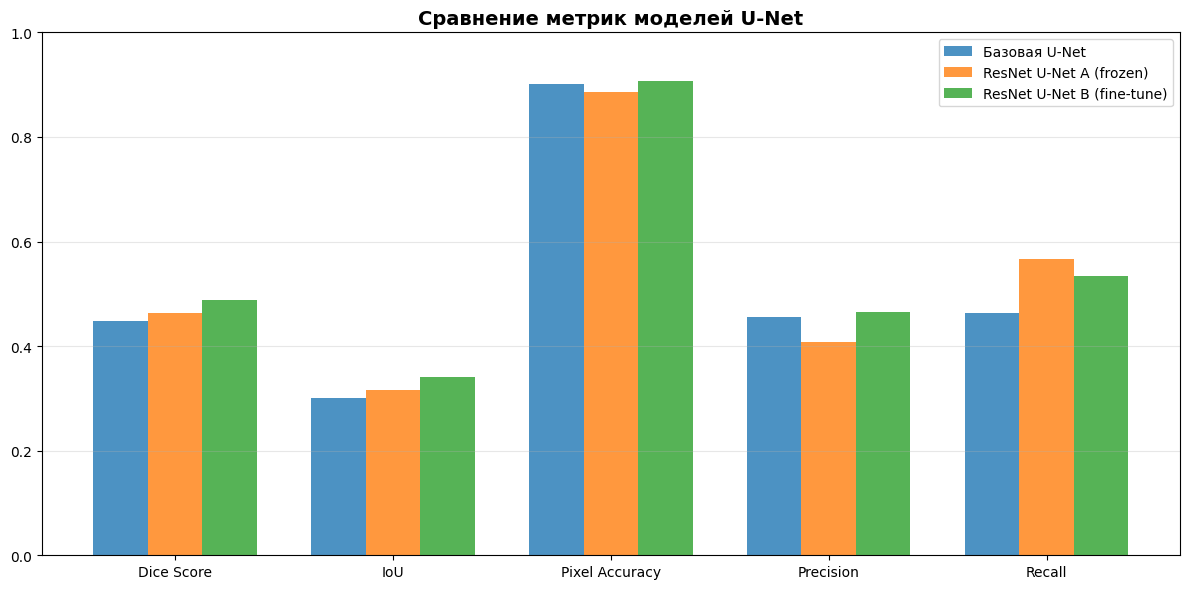

In [64]:
# График сравнения метрик
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

metrics_names = ['Dice Score', 'IoU', 'Pixel Accuracy', 'Precision', 'Recall']
x = np.arange(len(metrics_names))
width = 0.25

baseline_values = [metrics_baseline['Dice'], metrics_baseline['IoU'],
                   metrics_baseline['Pixel Accuracy'], metrics_baseline['Precision'],
                   metrics_baseline['Recall']]
A_values = [metrics_A['Dice'], metrics_A['IoU'],
            metrics_A['Pixel Accuracy'], metrics_A['Precision'],
            metrics_A['Recall']]
B_values = [metrics_B['Dice'], metrics_B['IoU'],
            metrics_B['Pixel Accuracy'], metrics_B['Precision'],
            metrics_B['Recall']]

ax.bar(x - width, baseline_values, width, label='Базовая U-Net', alpha=0.8)
ax.bar(x, A_values, width, label='ResNet U-Net A (frozen)', alpha=0.8)
ax.bar(x + width, B_values, width, label='ResNet U-Net B (fine-tune)', alpha=0.8)

ax.set_title('Сравнение метрик моделей U-Net', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])
plt.tight_layout()
plt.show()